In [1]:
!pip install accelerate
!pip install -i https://pypi.org/simple/ bitsandbytes
!pip install langchain langchain_openai langchain_community
!git clone https://github.com/saprmarks/geometry-of-truth.git

Looking in indexes: https://pypi.org/simple/
fatal: destination path 'geometry-of-truth' already exists and is not an empty directory.


In [2]:
from google.colab import drive, userdata
import os
drive.mount('/content/drive')
drive_dir = '/content/drive/My Drive/'
data_dir = os.path.join(drive_dir, 'Detection-datasets')
cache_dir = os.path.join(drive_dir, 'model_cache')
openai_api_key = userdata.get('OPENAI_API_KEY')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Datasets

In [3]:
import shutil

for ds_name in ["cities", "common_claim_true_false", "counterfact_true_false"]:
  shutil.copyfile(os.path.join("geometry-of-truth", "datasets", ds_name + ".csv"), os.path.join(data_dir, ds_name + ".csv"))

In [4]:
import pandas as pd

df = pd.read_csv(os.path.join(data_dir, 'cities.csv'))
df["Questions"] = df.apply(lambda row: f"Is {row['city']} in {row['country']}?", axis=1)
df = df.rename(columns={"statement": "Statements", "label": "isTrue"})
df.to_csv(os.path.join(data_dir, "cities_prepared_experiment_1.csv"))
assert os.path.isfile(os.path.join(data_dir, "cities_prepared_experiment_1.csv"))

In [5]:
df = pd.read_csv(os.path.join(data_dir, 'common_claim_true_false.csv'))
df["Questions"] = df.apply(lambda row: f"Determine if the following statement is true: {row['statement']}.", axis=1)
df = df.rename(columns={"statement": "Statements", "label": "isTrue"})
df.to_csv(os.path.join(data_dir, "common_claim_true_false_prepared_experiment_1.csv"))
assert os.path.isfile(os.path.join(data_dir, "common_claim_true_false_prepared_experiment_1.csv"))

In [6]:
df = pd.read_csv(os.path.join(data_dir, 'counterfact_true_false.csv'))
df["Questions"] = df.apply(lambda row: f"Determine if the following statement is true: {row['statement']}.", axis=1)
df = df.rename(columns={"statement": "Statements", "label": "isTrue"})
df.to_csv(os.path.join(data_dir, "counterfact_true_false_prepared_experiment_1.csv"))
assert os.path.isfile(os.path.join(data_dir, "counterfact_true_false_prepared_experiment_1.csv"))

In [7]:
import pandas as pd

def load_dataset(dataset_name):
  df = pd.read_csv(os.path.join(data_dir, dataset_name + '.csv'))
  idx = 50
  df_concat = pd.concat((df.loc[df['isTrue'] == 0][0:idx], df.loc[df['isTrue'] == 1][0:idx]))
  return df_concat

datasets = [(dataset_name, load_dataset(dataset_name)) for dataset_name in ["cities_prepared_experiment_1", "common_claim_true_false_prepared_experiment_1", "counterfact_true_false_prepared_experiment_1"]]
datasets += [("Politicians", load_dataset(os.path.join(data_dir, "Politicians_prepared")))]

# CI

In [8]:
from scipy.stats import beta
import numpy as np

def jeffrey_CI(is_correct, ci_alpha=0.05):
  N = len(is_correct)
  m = np.sum(is_correct) #y_test_hat == y_test)
  a = m+0.5
  b = N-m+0.5
  CI = np.array([beta.ppf(q=q, a=a, b=b) for q in [ci_alpha/2., 1-ci_alpha/2.]])
  CI = [f"{(c*100):.0f}%" for c in CI]
  return CI, N

In [9]:
import numpy as np

def bootstrap_CI(p, alpha=0.05, k=2000):
  """
    Computes the confidence interval of the mean using bootstrapping.
    Here the confidence interval is the 100*(1-alpha) central CI, from percentile 100*(alpha/2) to 100*(1-alpha/2) rounded to broadest interval when picking the indices.
    Line Clemmensen suggests picking k (number of repeats) to 1000 or 2000 for this tasks, so I do this.
  """
  assert isinstance(p, np.ndarray)
  assert p.ndim == 1
  N = len(p)
  bootstraps = np.random.choice(p, (k,N), replace=True)
  ci_lower = alpha/2.
  ci_upper = 1.-(alpha/2.)
  idxs = [
    int(np.floor(k*ci_lower)),
    int(np.ceil(k*ci_upper))
  ]
  CI = np.sort(np.mean(bootstraps, axis=-1))[idxs]     # Sorts lowest to highest
  assert CI[0] <= CI[1]  # To be on the safe side...
  CI = [f"{(c*100):.0f}%" for c in CI]
  return CI, N    # Returns CI and support (N)

# OpenAI LLM output parser
https://python.langchain.com/docs/modules/model_io/output_parsers/types/pydantic/<br>
https://python.langchain.com/docs/modules/model_io/prompts/few_shot_examples_chat/<br>
Note: This parser should be evaluated for accuracy!

In [10]:
from typing import List

from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain_openai import ChatOpenAI, OpenAI
from langchain.prompts.few_shot import FewShotPromptTemplate
from langchain_community.callbacks import get_openai_callback
from langchain_core.exceptions import OutputParserException

model = OpenAI(name="gpt-3.5-turbo-0125", temperature=0, api_key=openai_api_key)

In [11]:
class Polarity(BaseModel):
    value: int = Field(description="a value indicating the polarity of a statement, where 1 means true, 0 means false, and -1 for everything else.")

assert Polarity(value=0) == Polarity(value=0)
assert Polarity(value=0) != Polarity(value=1)

parser = PydanticOutputParser(pydantic_object=Polarity)

examples = [
    {"question": "Did Mette Frederiksen attend Aarhus University?", "answer": "No, Mette Frederiksen did not attend Aarhus University, she attended University of Copenhagen and Aalborg University.", "output": "{{\"value\": 0}}"},
    {"question": "Did Mette Frederiksen attend Aarhus University?", "answer": "Yes, Mette Frederiksen attended Aarhus University in the years 3000-3005.", "output": "{{\"value\": 1}}"},
    {"question": "Did Mette Frederiksen attend Aarhus University?", "answer": "No, Mette Frederiksen did not attend Aalborg University.", "output": "{{\"value\": -1}}"},
    {"question": "Did Mette Frederiksen attend Aarhus University?", "answer": "Did Mette Frederiksen attend Aarhus University?", "output": "{{\"value\": -1}}"},
    {"question": "Did Mette Frederiksen attend Aarhus University?", "answer": "No, Mette Frederiksen attended Aarhus University?", "output": "{{\"value\": -1}}"},
    {"question": "Did Narendra Modi attend Gujarat University?", "answer": "[INST] Did Narendra Modi attend Gujarat University? [/INST] [/INST] [/INST] [/INST]", "output": "{{\"value\": -1}}"}
]
example_prompt = PromptTemplate(
    input_variables=["question", "answer", "output"],
    template="User: Question: {question}\nAnswer: {answer}\nAssistant: {output}"
)
prompt = FewShotPromptTemplate(
    prefix="Extract the assistant's answer to the question into a JSON format. Use 1 to signify agreement, 0 to signify disagreement, and -1 if the answer is not usable.",
    examples=examples,
    example_prompt=example_prompt,
    suffix="User: Question: {question}\nAnswer: {answer}\nAssistant: ",
    input_variables=["question", "answer"]
)

chain = prompt | model | parser

# Read internal representations + get model predictions

In [12]:
from typing import List
import transformers
from tqdm.notebook import tqdm
import numpy as np
import torch

dtype = np.float16


class Hook:
  # Inspired by https://github.com/saprmarks/geometry-of-truth/blob/main/generate_acts.py
  def __init__(self):
    self.activations = []
    self.idx = -1   # The index of the token we look at the internal state for

  def __call__(self, module, args, output, **kwargs):
    assert len(output) == 2 and isinstance(output[1], transformers.cache_utils.DynamicCache) and isinstance(output[0], torch.Tensor)
    o = output[0][...,self.idx,:].detach().cpu().numpy().astype(dtype)
    self.activations.append(o)


def compute_activations(statements: List[str], model: torch.nn.Module, tokenizer) -> np.ndarray:
  """
    Returns:
    - Activations of shape [num_layers, num_samples, n_hidden_dim]
  """
  # Empty forward hooks just in case something happened.
  for layer in model.model.layers:
    layer._forward_hooks.clear()
    assert not len(layer._forward_hooks)

  hooks = []
  handles = []
  for i, layer in enumerate(model.model.layers):
    hook = Hook()
    handle = layer.register_forward_hook(hook)
    hooks.append(hook)
    handles.append(handle)

  for statement in tqdm(statements):
    tokens = tokenizer.encode(statement, return_tensors='pt').cuda()
    _ = model(tokens)

  for handle in handles:
    handle.remove()

  activations = []
  for hook in hooks:
    activations.append(np.vstack(hook.activations))

  return np.stack(activations, axis=0)


def make_llm_predictions_with_probs(df, model, tokenizer):
  questions = df["Questions"].tolist()
  statements = df["Statements"].tolist()
  labels = df["isTrue"].to_numpy()

  probabilities = []
  for i in tqdm(range(len(questions))):
    text = tokenizer.apply_chat_template([{"role": "user", "content": questions[i]}], tokenize=False, add_generation_prompt=True) + "\n"
    tokens = tokenizer(text, return_tensors="pt", add_special_tokens=True)
    tokens = {k:v.cuda() for k,v in tokens.items()}
    out = model(**tokens)
    probs = torch.nn.functional.softmax(out['logits'][0,-1,:],dim=0).cpu().detach().numpy()
    probabilities.append(probs)
  probabilities = np.array(probabilities)  # Has same order as in `activations`.
  assert np.all(np.isclose(np.sum(probabilities, axis=1), 1.0))
  yes_no_probs = probabilities[:,[tokenizer.vocab["No"], tokenizer.vocab["Yes"]]]
  pred = np.argmax(yes_no_probs, axis=1)
  df["Pred_from_probs"] = pred
  return df


def make_llm_predictions_with_generation_llm(df, model, tokenizer):
  questions = df["Questions"].tolist()
  statements = df["Statements"].tolist()
  labels = df["isTrue"].to_numpy()
  responses = []
  for i in tqdm(range(len(questions))):
    text = tokenizer.apply_chat_template([{"role": "user", "content": questions[i]}], tokenize=False, add_generation_prompt=True) + "\n"
    tokens = tokenizer(text, return_tensors="pt", add_special_tokens=True)
    tokens = {k:v.cuda() for k,v in tokens.items()}
    out = model.generate(**tokens, max_new_tokens=32, do_sample=False, temperature=None, top_p=None)
    out = tokenizer.decode(out[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)
    out = out.replace(text, '')
    responses.append(out)
  df["Responses"] = np.array(responses)

  preds = []
  with get_openai_callback() as cb:
    for q, r in tqdm(zip(questions, responses)):
      try:
        out = chain.invoke({"question": q, "answer": r})
        preds.append(out.value)
      except OutputParserException:
        preds.append(-2)
  print(f"Total price of evaluation: ${cb.total_cost}")
  df["Pred_from_gens"] = np.array(preds)
  return df

# Plots

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


activations = None

def plot_labeled_pca(layer, n_components, df_concat, pred_col, activations):
    X, y, y_hat = activations[layer,...], df_concat['isTrue'], df_concat[pred_col]
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    fig, ax = plt.subplots(n_components, n_components, figsize=(20,20))
    for x_component in range(n_components):
      for y_component in range(n_components):
        ax[x_component, y_component].scatter(X_pca[(y==0) & (y_hat == 0), x_component], X_pca[(y==0) & (y_hat == 0), y_component], label="False, predicted false", color='tab:blue', marker='x')
        ax[x_component, y_component].scatter(X_pca[(y==0) & (y_hat == 1), x_component], X_pca[(y==0) & (y_hat == 1), y_component], label="False, predicted true", color='tab:blue', marker='o')
        ax[x_component, y_component].scatter(X_pca[(y==1) & (y_hat == 0), x_component], X_pca[(y==1) & (y_hat == 0), y_component], label="True, predicted false", color='tab:orange', marker='o')
        ax[x_component, y_component].scatter(X_pca[(y==1) & (y_hat == 1), x_component], X_pca[(y==1) & (y_hat == 1), y_component], label="True, predicted true", color='tab:orange', marker='x')
        ax[x_component, y_component].set_title(f'x: {x_component}, y: {y_component}')
    plt.legend(loc=(1.04, n_components))

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def prob_plot(probs, tokenizer, top_n_text=10):
  tokens_to_str = {v:k for k,v in tokenizer.vocab.items()}
  if isinstance(probs, torch.Tensor):
    p = probs.cpu().detach().numpy()
  else:
    p=probs
  xs = np.vstack([np.arange(len(p))]*2)
  ys = np.vstack((np.zeros(p.shape),p))
  plt.plot(xs, ys)
  highest = np.argsort(p)[-top_n_text:]
  for tok in highest:
    text = tokens_to_str[tok]
    plt.text(tok, p[tok], text)
  plt.show()

# Models

In [15]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

models = ["meta-llama/Llama-2-13b-hf", "meta-llama/Llama-2-13b-chat-hf"]

def load_model(model_name):
  from transformers import AutoModelForCausalLM, AutoTokenizer
  quantization_config = BitsAndBytesConfig(
      load_in_4bit=True,
      bnb_4bit_compute_dtype=torch.float16,
  )

  model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", cache_dir=cache_dir, quantization_config=quantization_config)
  tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)

  model.config.pad_token_id = 32000
  model.resize_token_embeddings(32001)
  model.model.padding_idx = 32000
  model.model.embed_tokens.padding_idx = 32000
  tokenizer.add_special_tokens({"pad_token": "<pad>"})
  new_chat_template = tokenizer.default_chat_template
  new_chat_template = new_chat_template.replace("bos_token + ", "")
  tokenizer.chat_template = new_chat_template
  tokenizer.instruction_template = "[INST]"
  tokenizer.response_template = "[/INST]"
  return model, tokenizer

# Experiment

In [16]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


def experiment(dataset_name, df_concat, model_name, model, tokenizer):
  make_llm_predictions_with_generation_llm(df_concat, model, tokenizer)
  make_llm_predictions_with_probs(df_concat, model, tokenizer)
  activations = compute_activations(df_concat['Statements'], model, tokenizer)   # [layers, statements, np.array([1,tokens,4096])]

  # Plots
  plot_labeled_pca(layer=14, n_components=5, df_concat=df_concat, pred_col="Pred_from_probs", activations=activations)
  plt.suptitle("LLM predictions from probs")
  plt.show()
  plot_labeled_pca(layer=14, n_components=5, df_concat=df_concat, pred_col="Pred_from_gens", activations=activations)
  plt.suptitle("LLM predictions from generation")
  plt.show()

  # CL
  y_true, y_hat = df_concat['isTrue'].to_numpy(), df_concat['Pred_from_probs'].to_numpy()
  cl_ci = jeffrey_CI(y_true==y_hat)
  cl_is_correct = (y_true==y_hat).astype(np.int32)

  # Generation
  y_true, y_hat = df_concat['isTrue'].to_numpy(), df_concat['Pred_from_gens'].to_numpy()
  N = len(y_true)
  y_true, y_hat = y_true[(y_hat!=-1) & (y_hat!=-2)], y_hat[(y_hat!=-1) & (y_hat!=-2)]
  generation_ci = jeffrey_CI(y_true==y_hat)
  N_rejected = N - len(y_true)
  n_true = np.sum(y_true)
  n_false = np.sum(1-y_true)
  generation_baseline = np.max((n_true, n_false))/(n_true+n_false)

  # Probes
  layer = 14
  X, y = activations[layer,...], df_concat['isTrue'].to_numpy()
  y_hats = []
  for train_idx, test_idx in KFold(n_splits=5).split(X, y):
      X_train, y_train, X_test, y_test = X[train_idx,...], y[train_idx], X[test_idx,...], y[test_idx]
      scaler = StandardScaler()
      X_train = scaler.fit_transform(X_train)
      X_test = scaler.transform(X_test)
      log_reg = LogisticRegression(max_iter=1000)
      log_reg.fit(X_train, y_train)
      y_pred = log_reg.predict(X_test)
      y_hats.append(y_pred)
  y_hats = np.hstack(y_hats)

  probe_pred = (y==y_hats).astype(np.int32)
  probe_ci = jeffrey_CI(probe_pred)

  d = probe_pred - cl_is_correct
  return {"Dataset": dataset_name, "Model": model_name, "Yes/No CL": cl_ci[0], "Linear probe accuracy": probe_ci[0], "Generation": generation_ci[0], "Generation baseline": generation_baseline, "Rejects": f"{N_rejected} of {N}"}, d, probe_pred, cl_is_correct

# Run experiment

Models:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Datasets:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Total price of evaluation: $0.05074349999999998


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

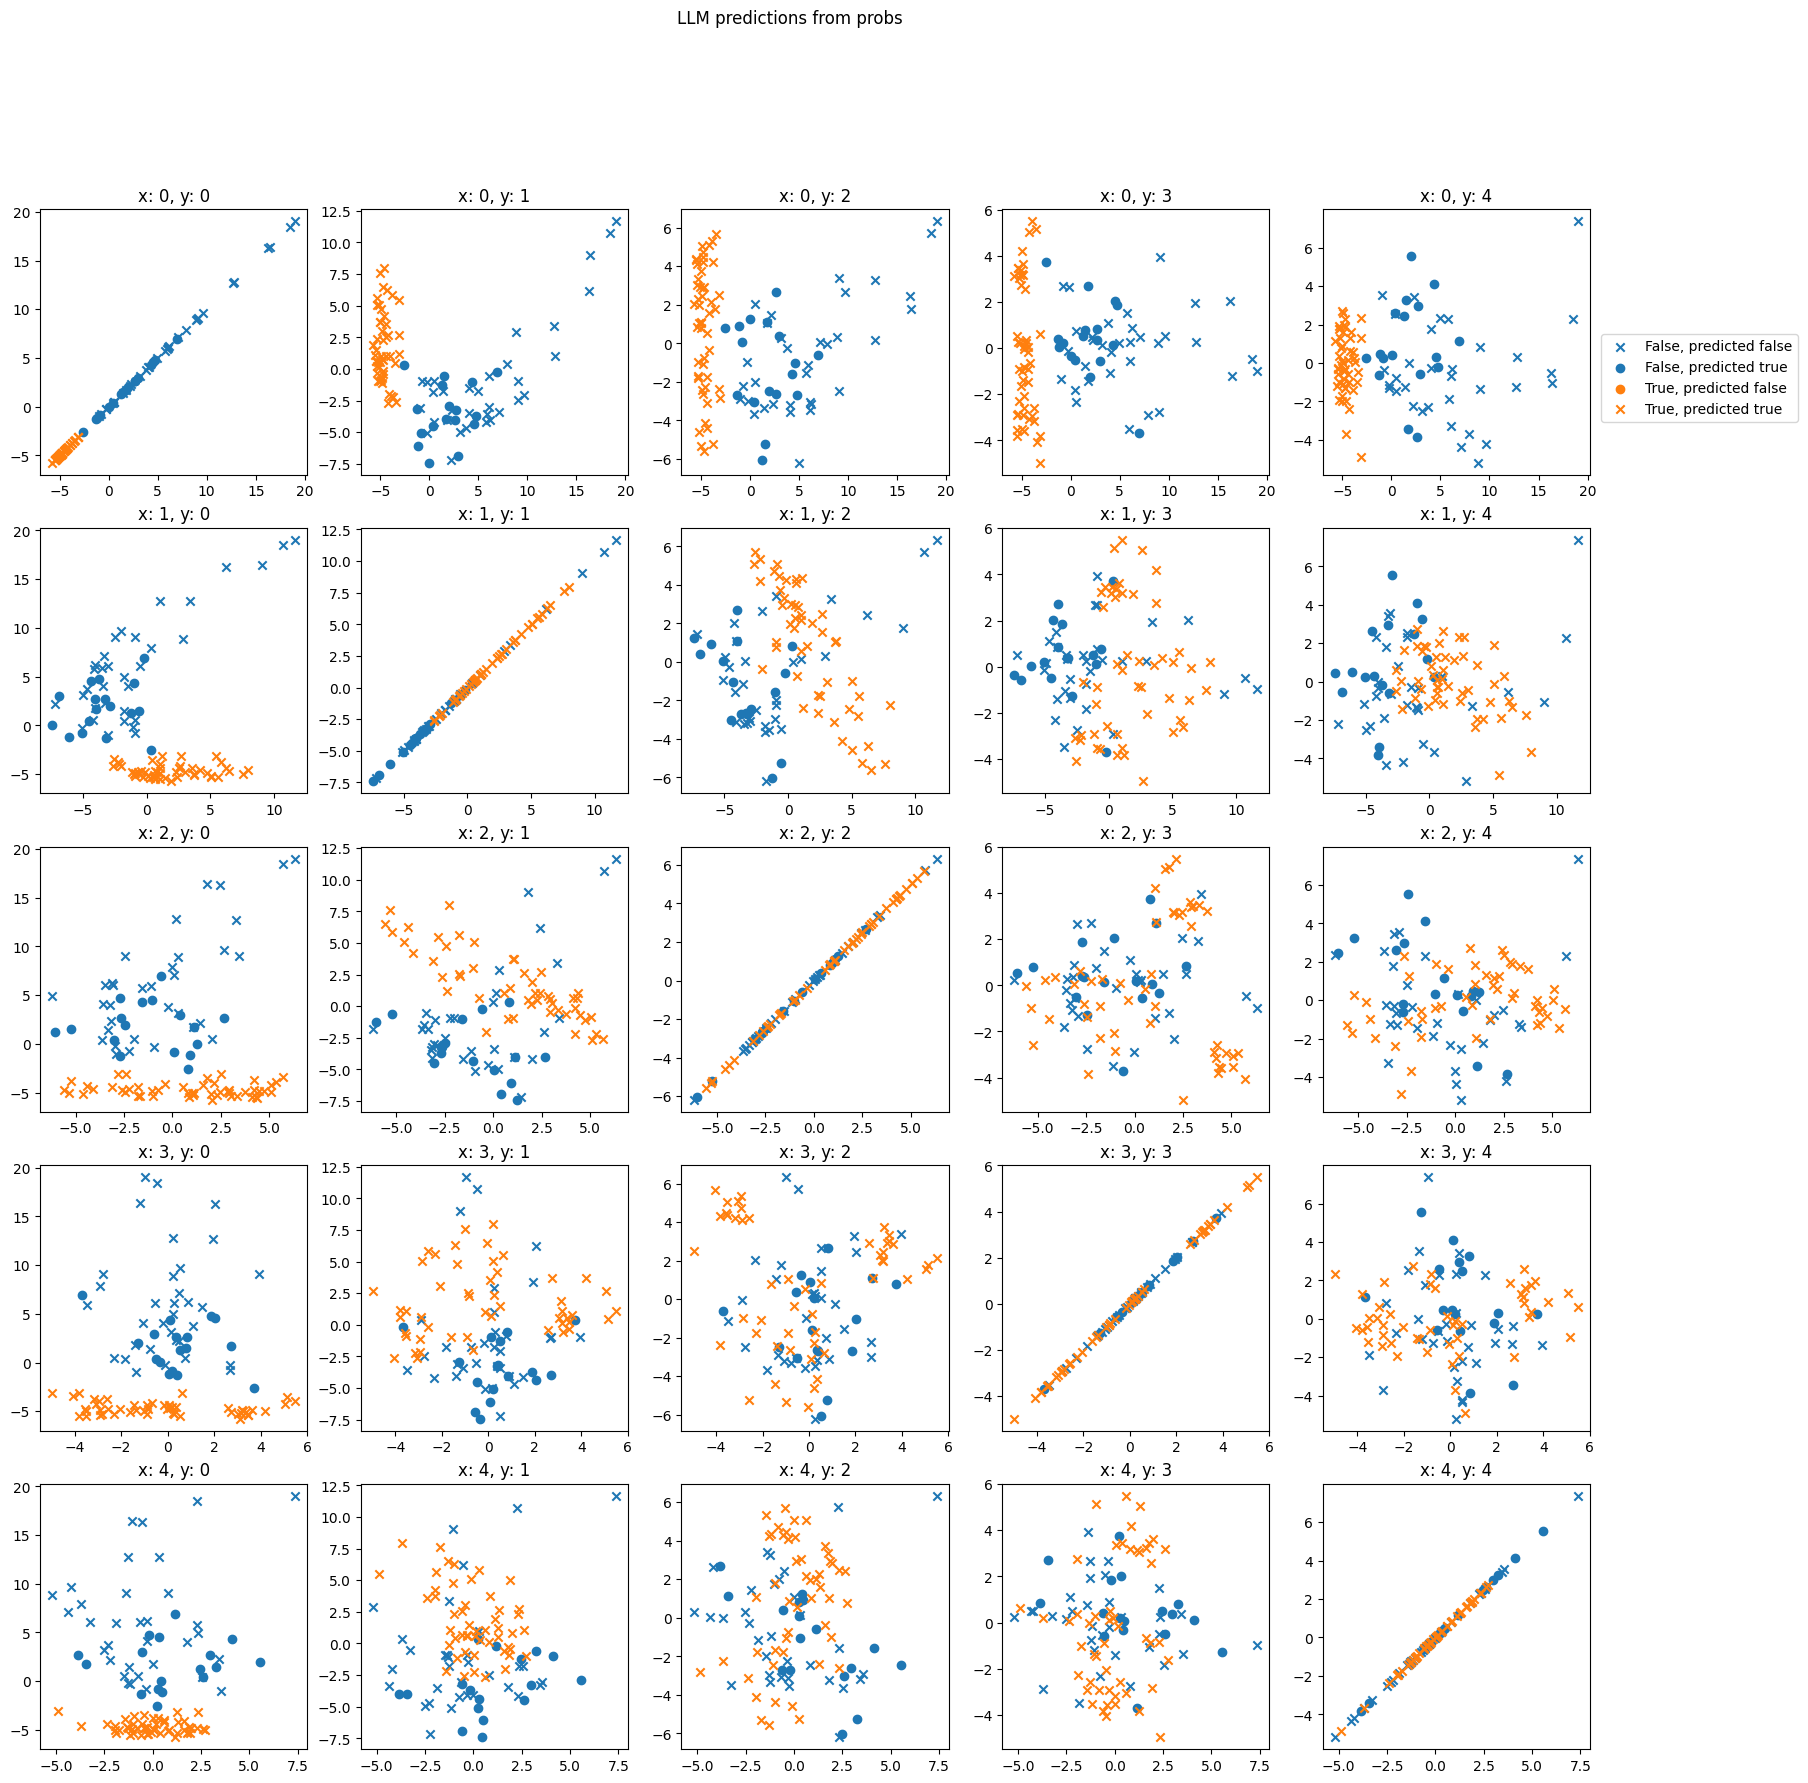

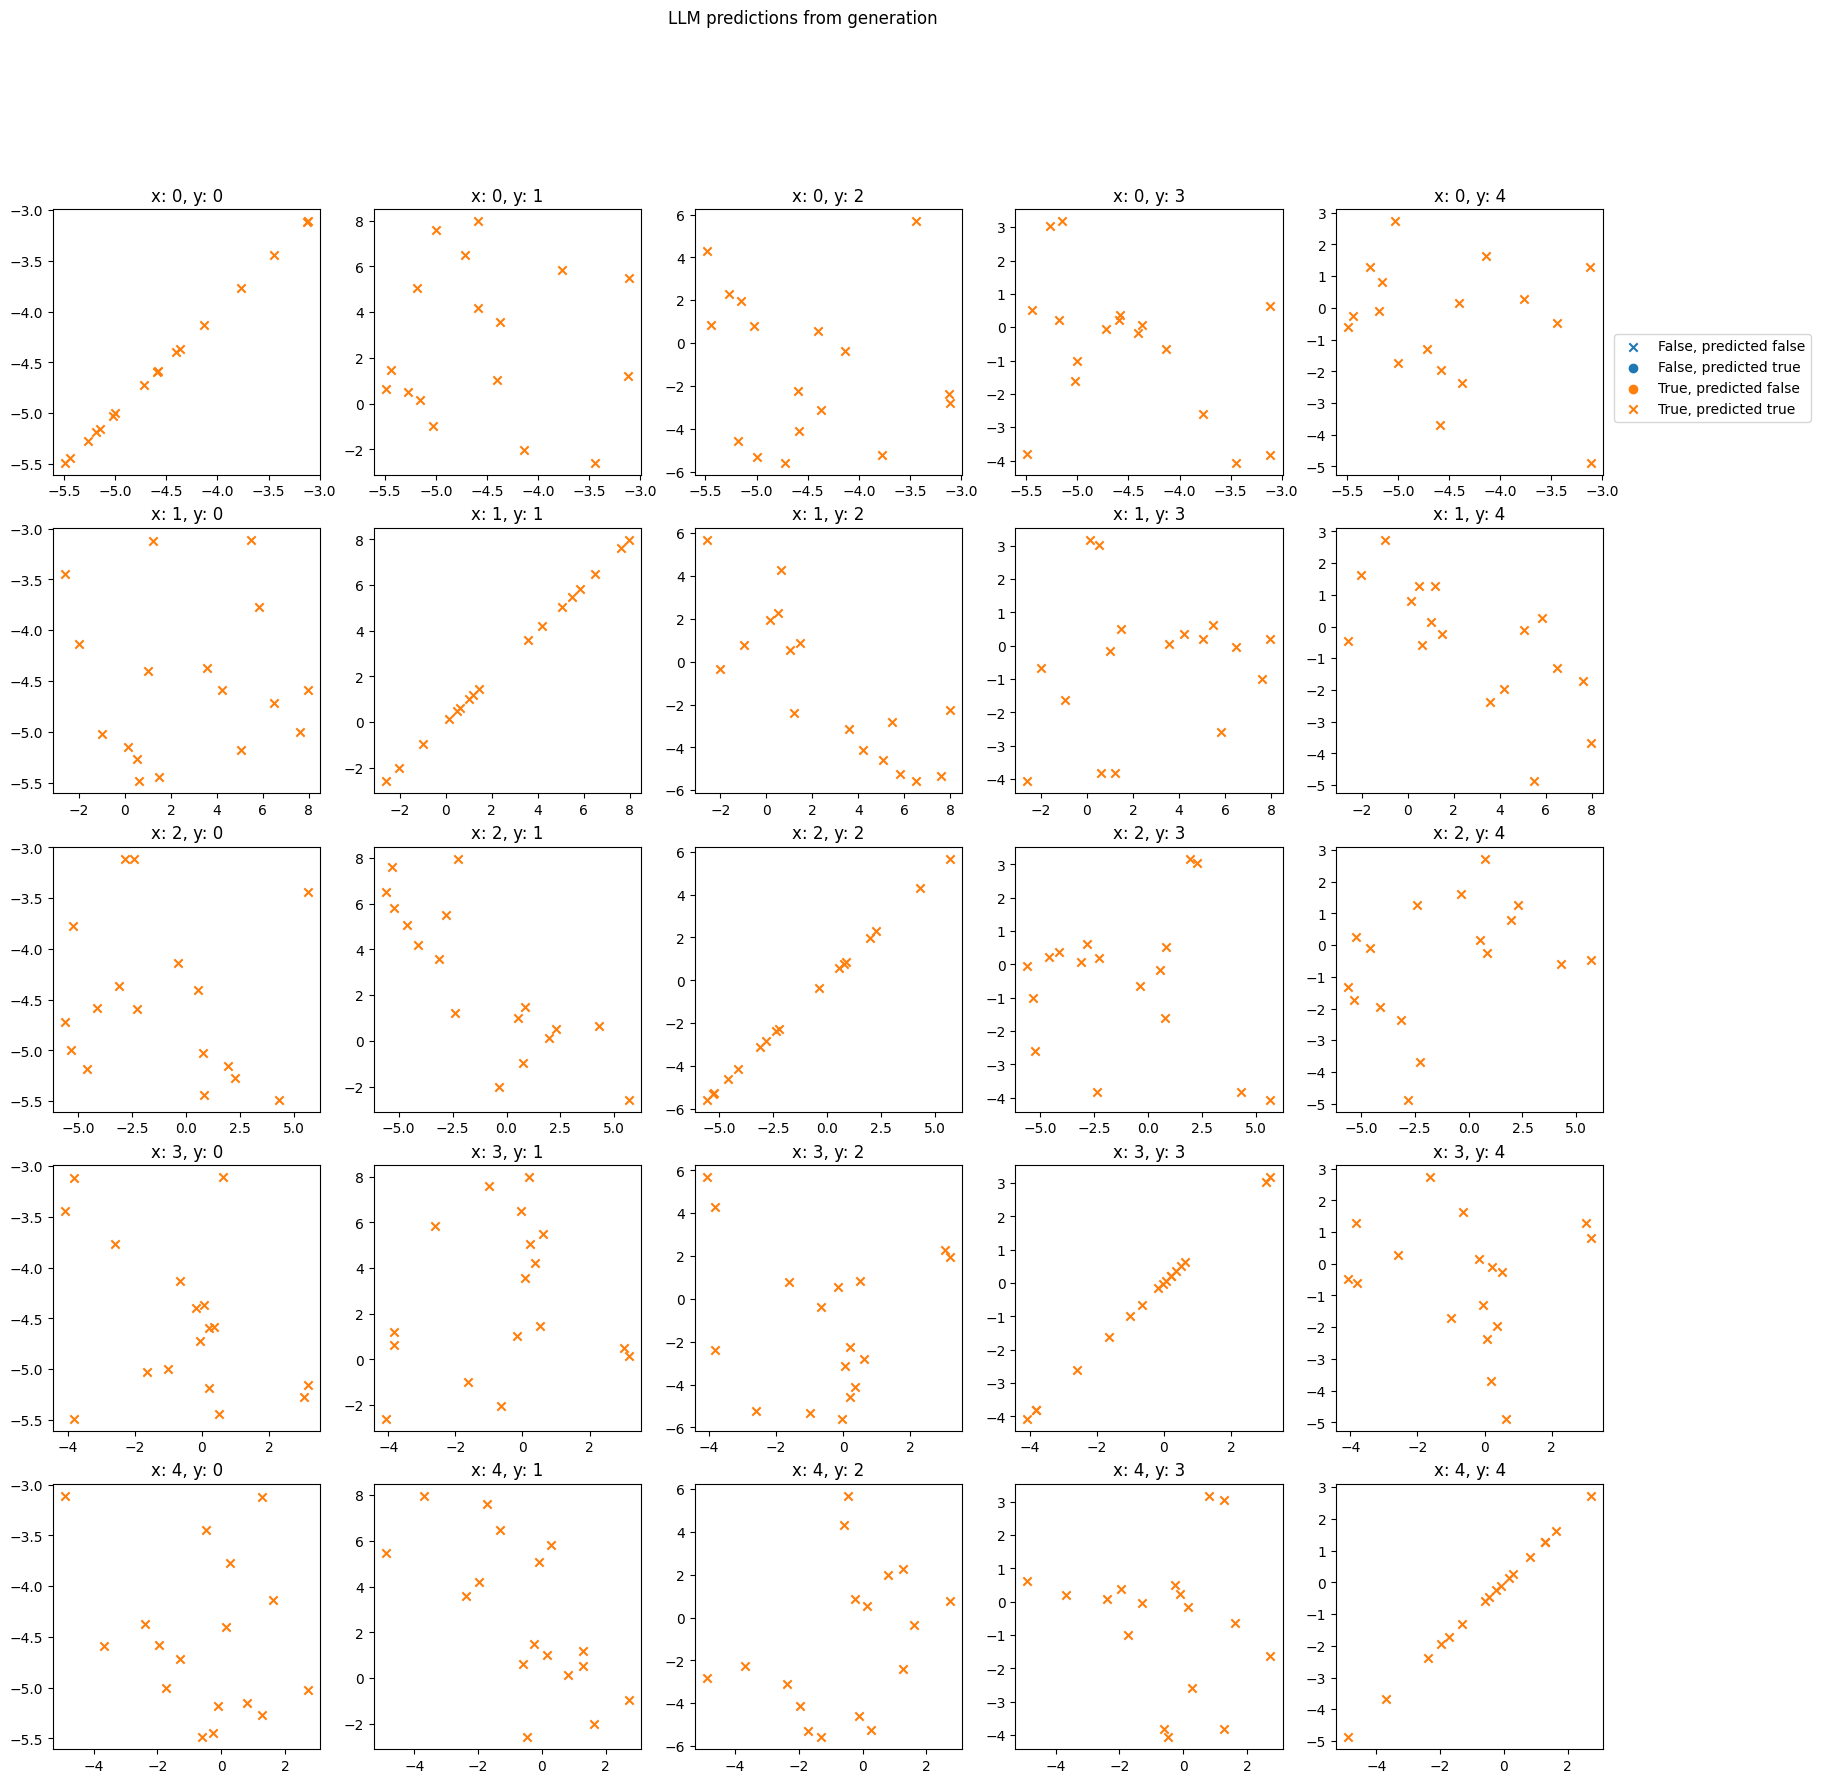

Dataset                      Model   Yes/No CL  \
0  cities_prepared_experiment_1  meta-llama/Llama-2-13b-hf  [75%, 89%]   

  Linear probe accuracy   Generation  Generation baseline    Rejects  
0           [95%, 100%]  [86%, 100%]                  1.0  83 of 100

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Total price of evaluation: $0.052788


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

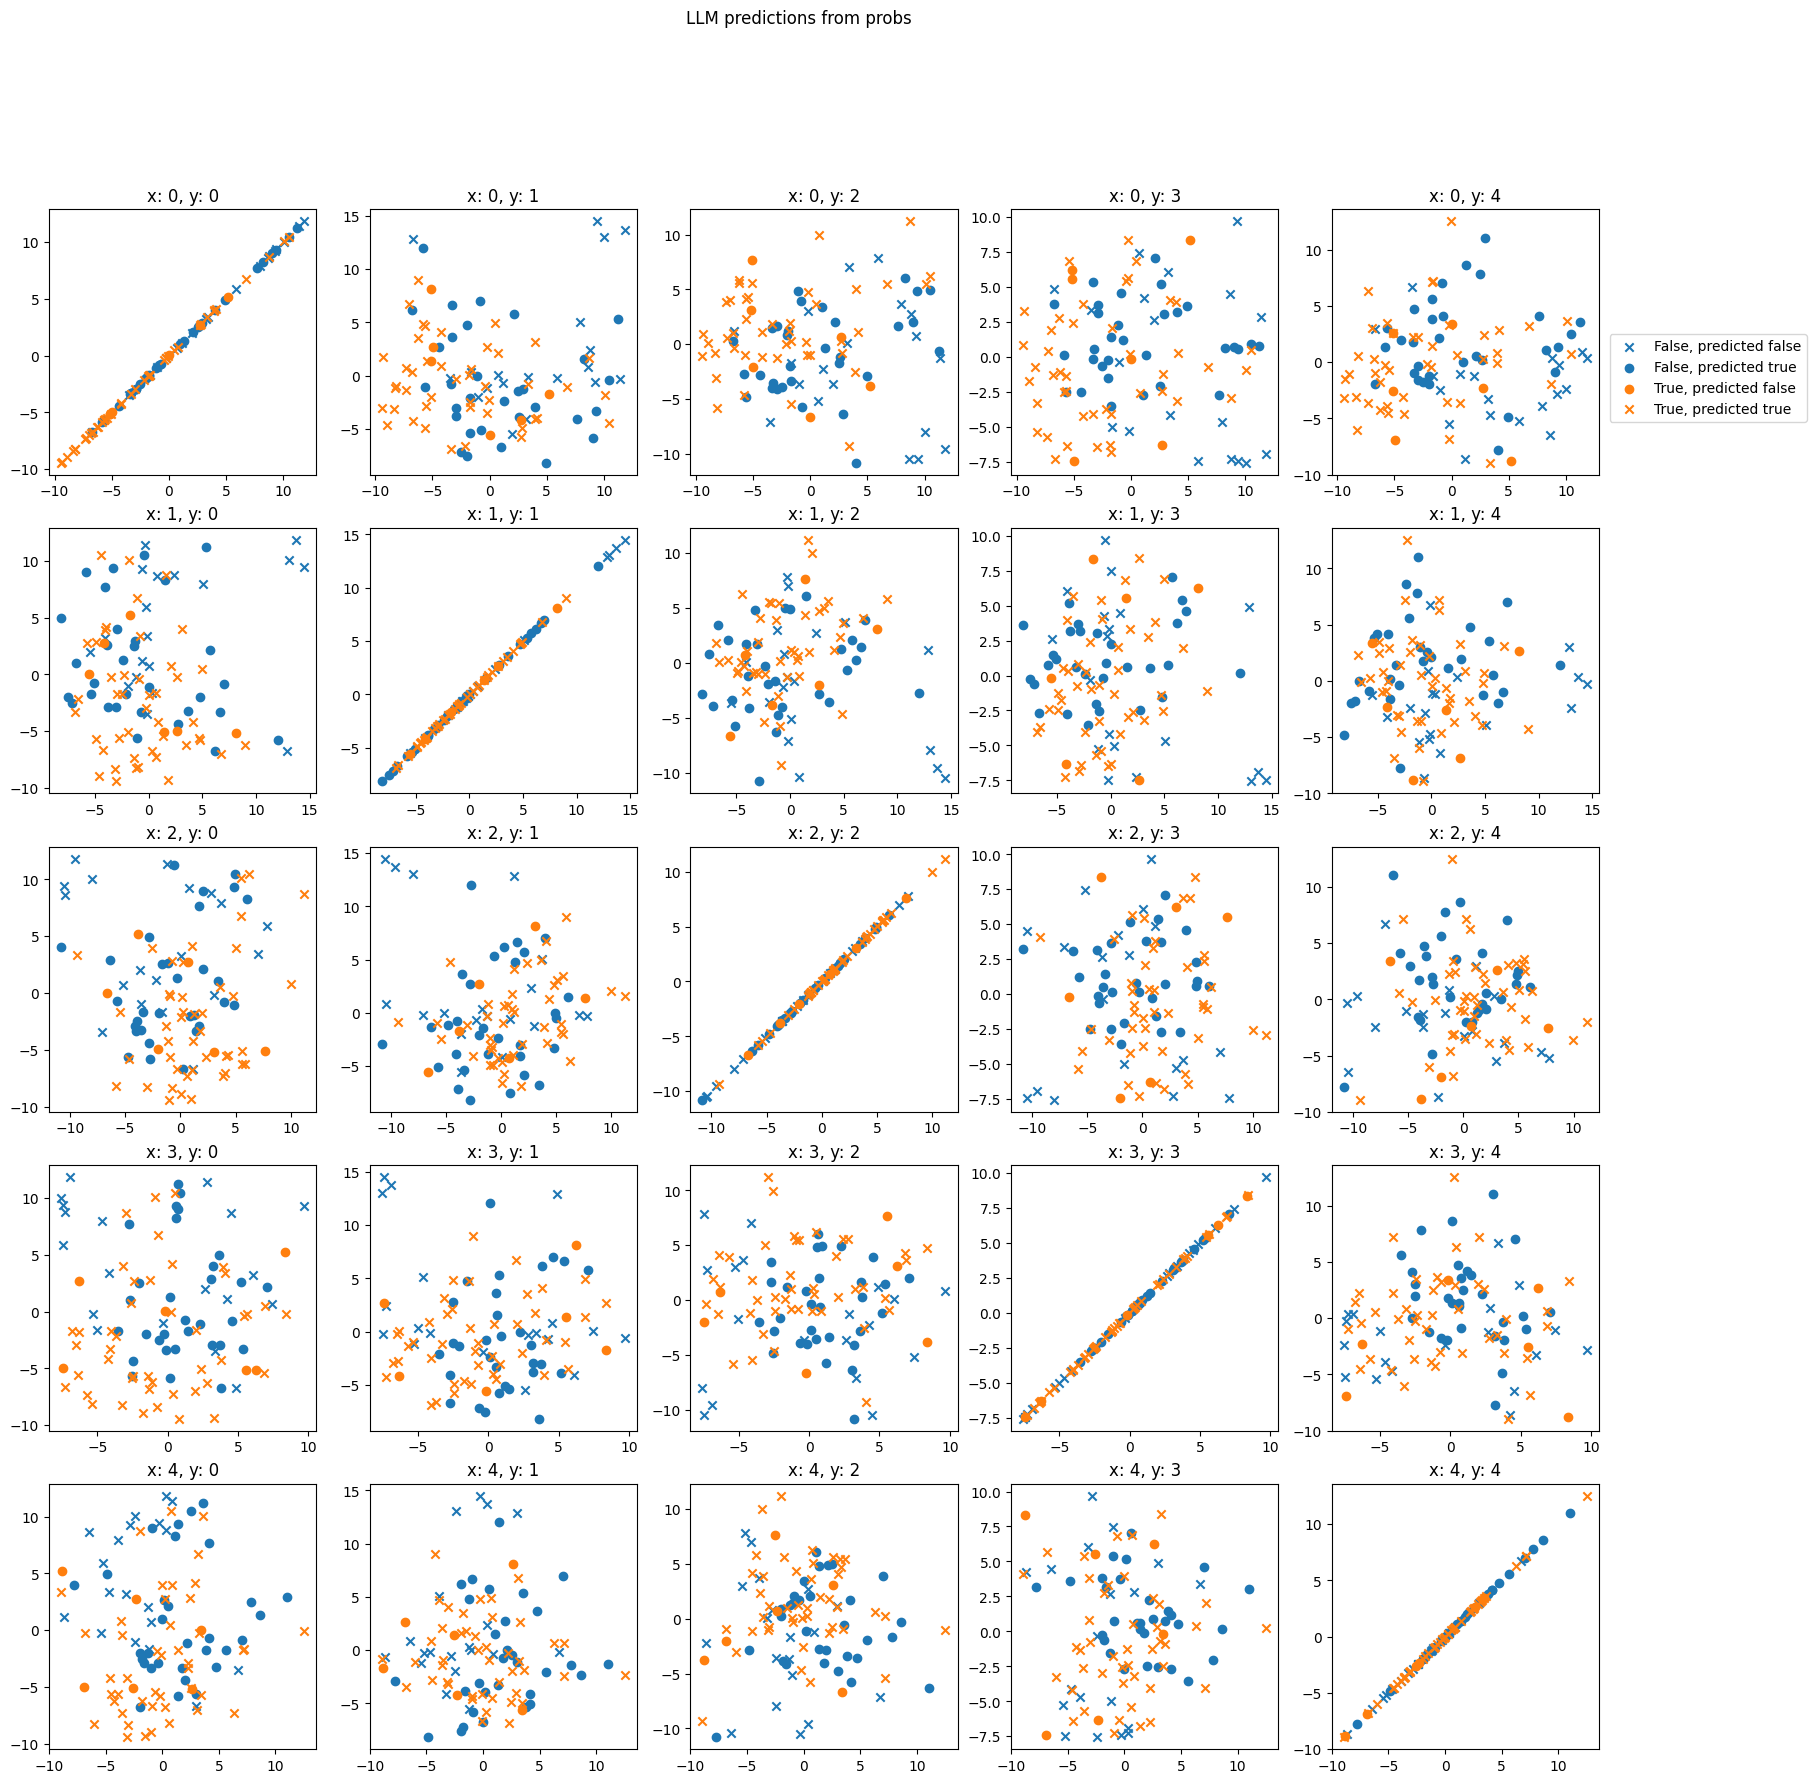

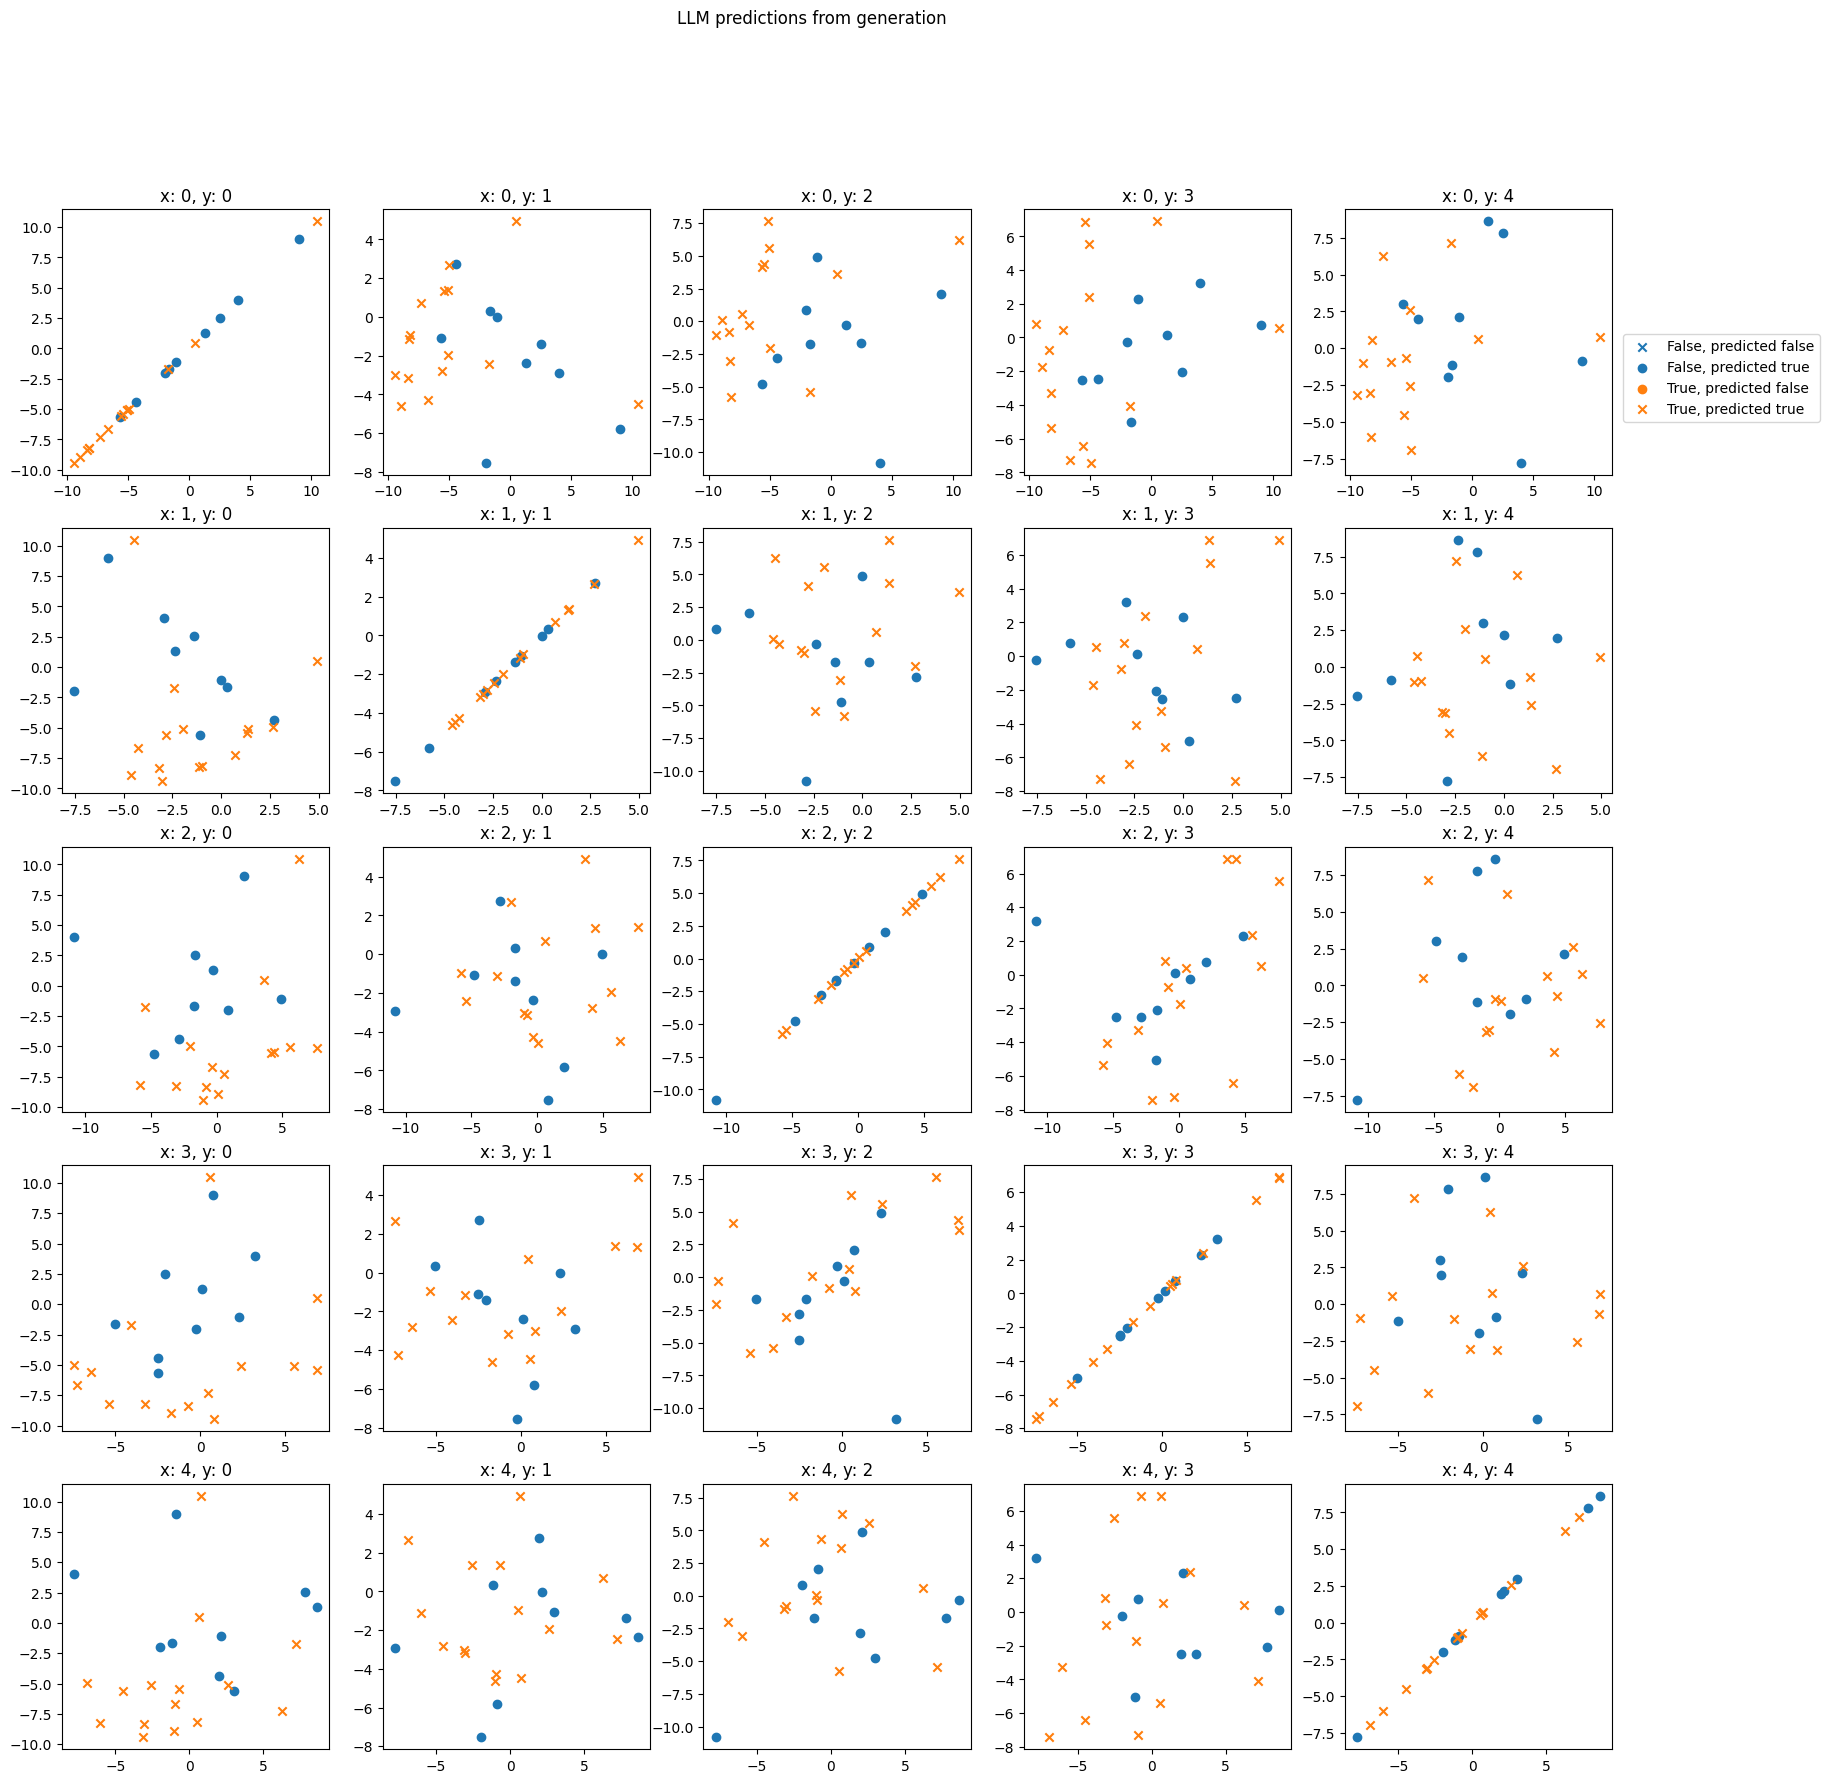

Dataset                      Model  \
0                   cities_prepared_experiment_1  meta-llama/Llama-2-13b-hf   
1  common_claim_true_false_prepared_experiment_1  meta-llama/Llama-2-13b-hf   

    Yes/No CL Linear probe accuracy   Generation  Generation baseline  \
0  [75%, 89%]           [95%, 100%]  [86%, 100%]                1.000   
1  [53%, 72%]            [44%, 64%]   [43%, 80%]                0.625   

     Rejects  
0  83 of 100  
1  76 of 100

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Total price of evaluation: $0.05221100000000002


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

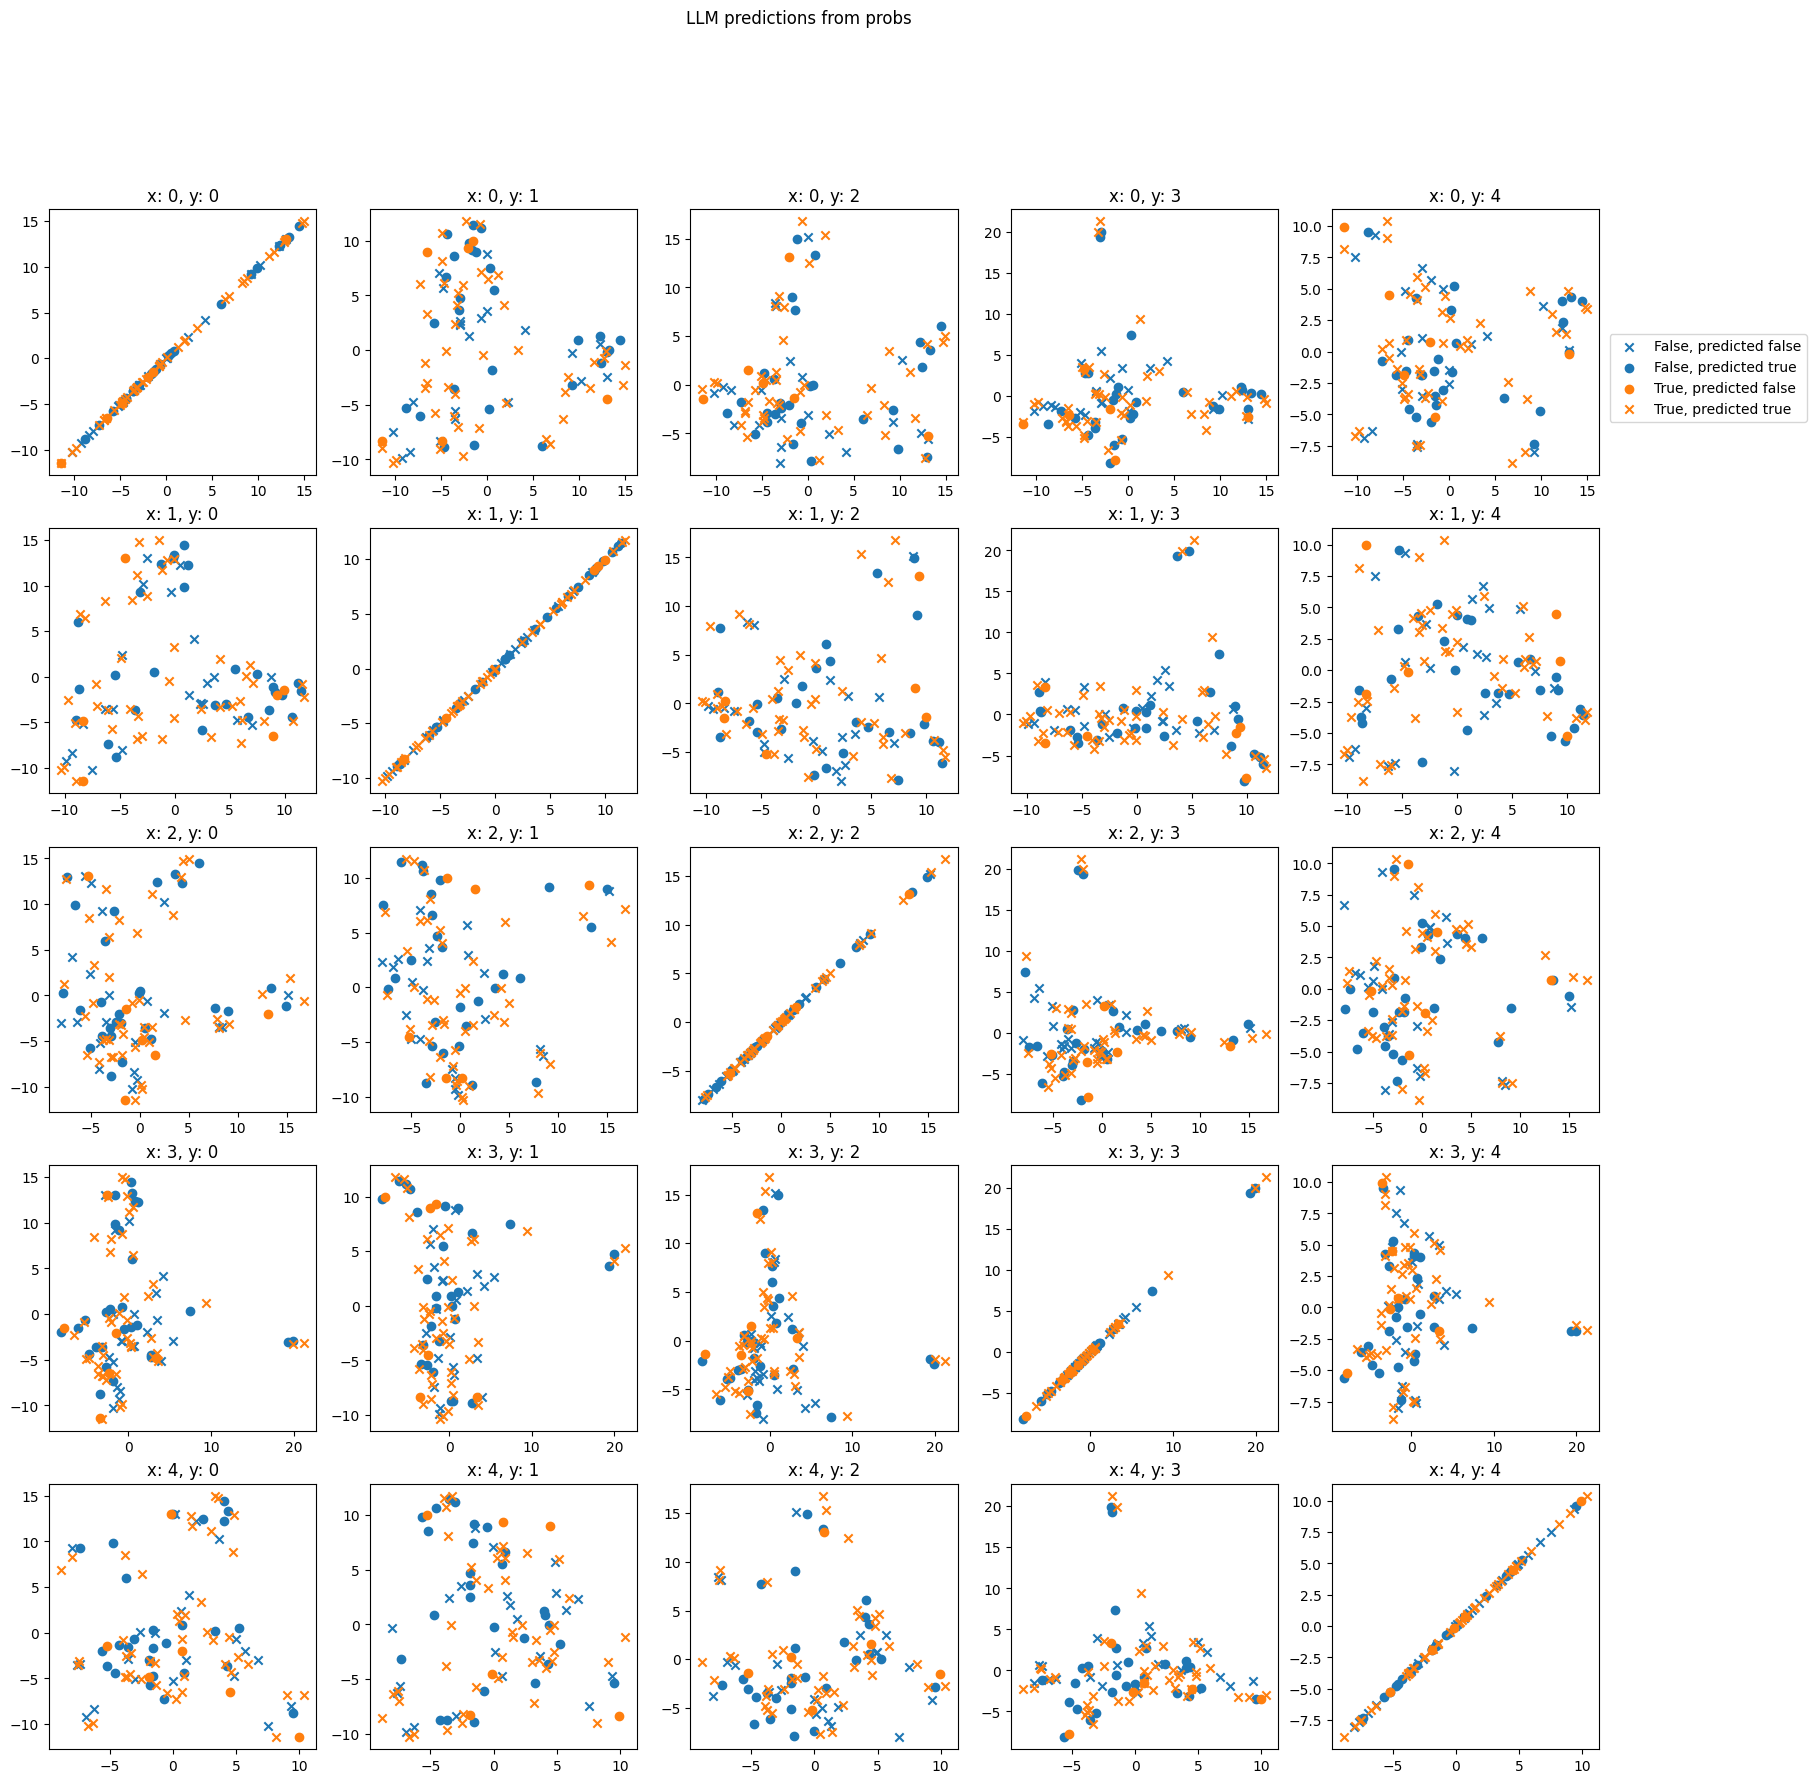

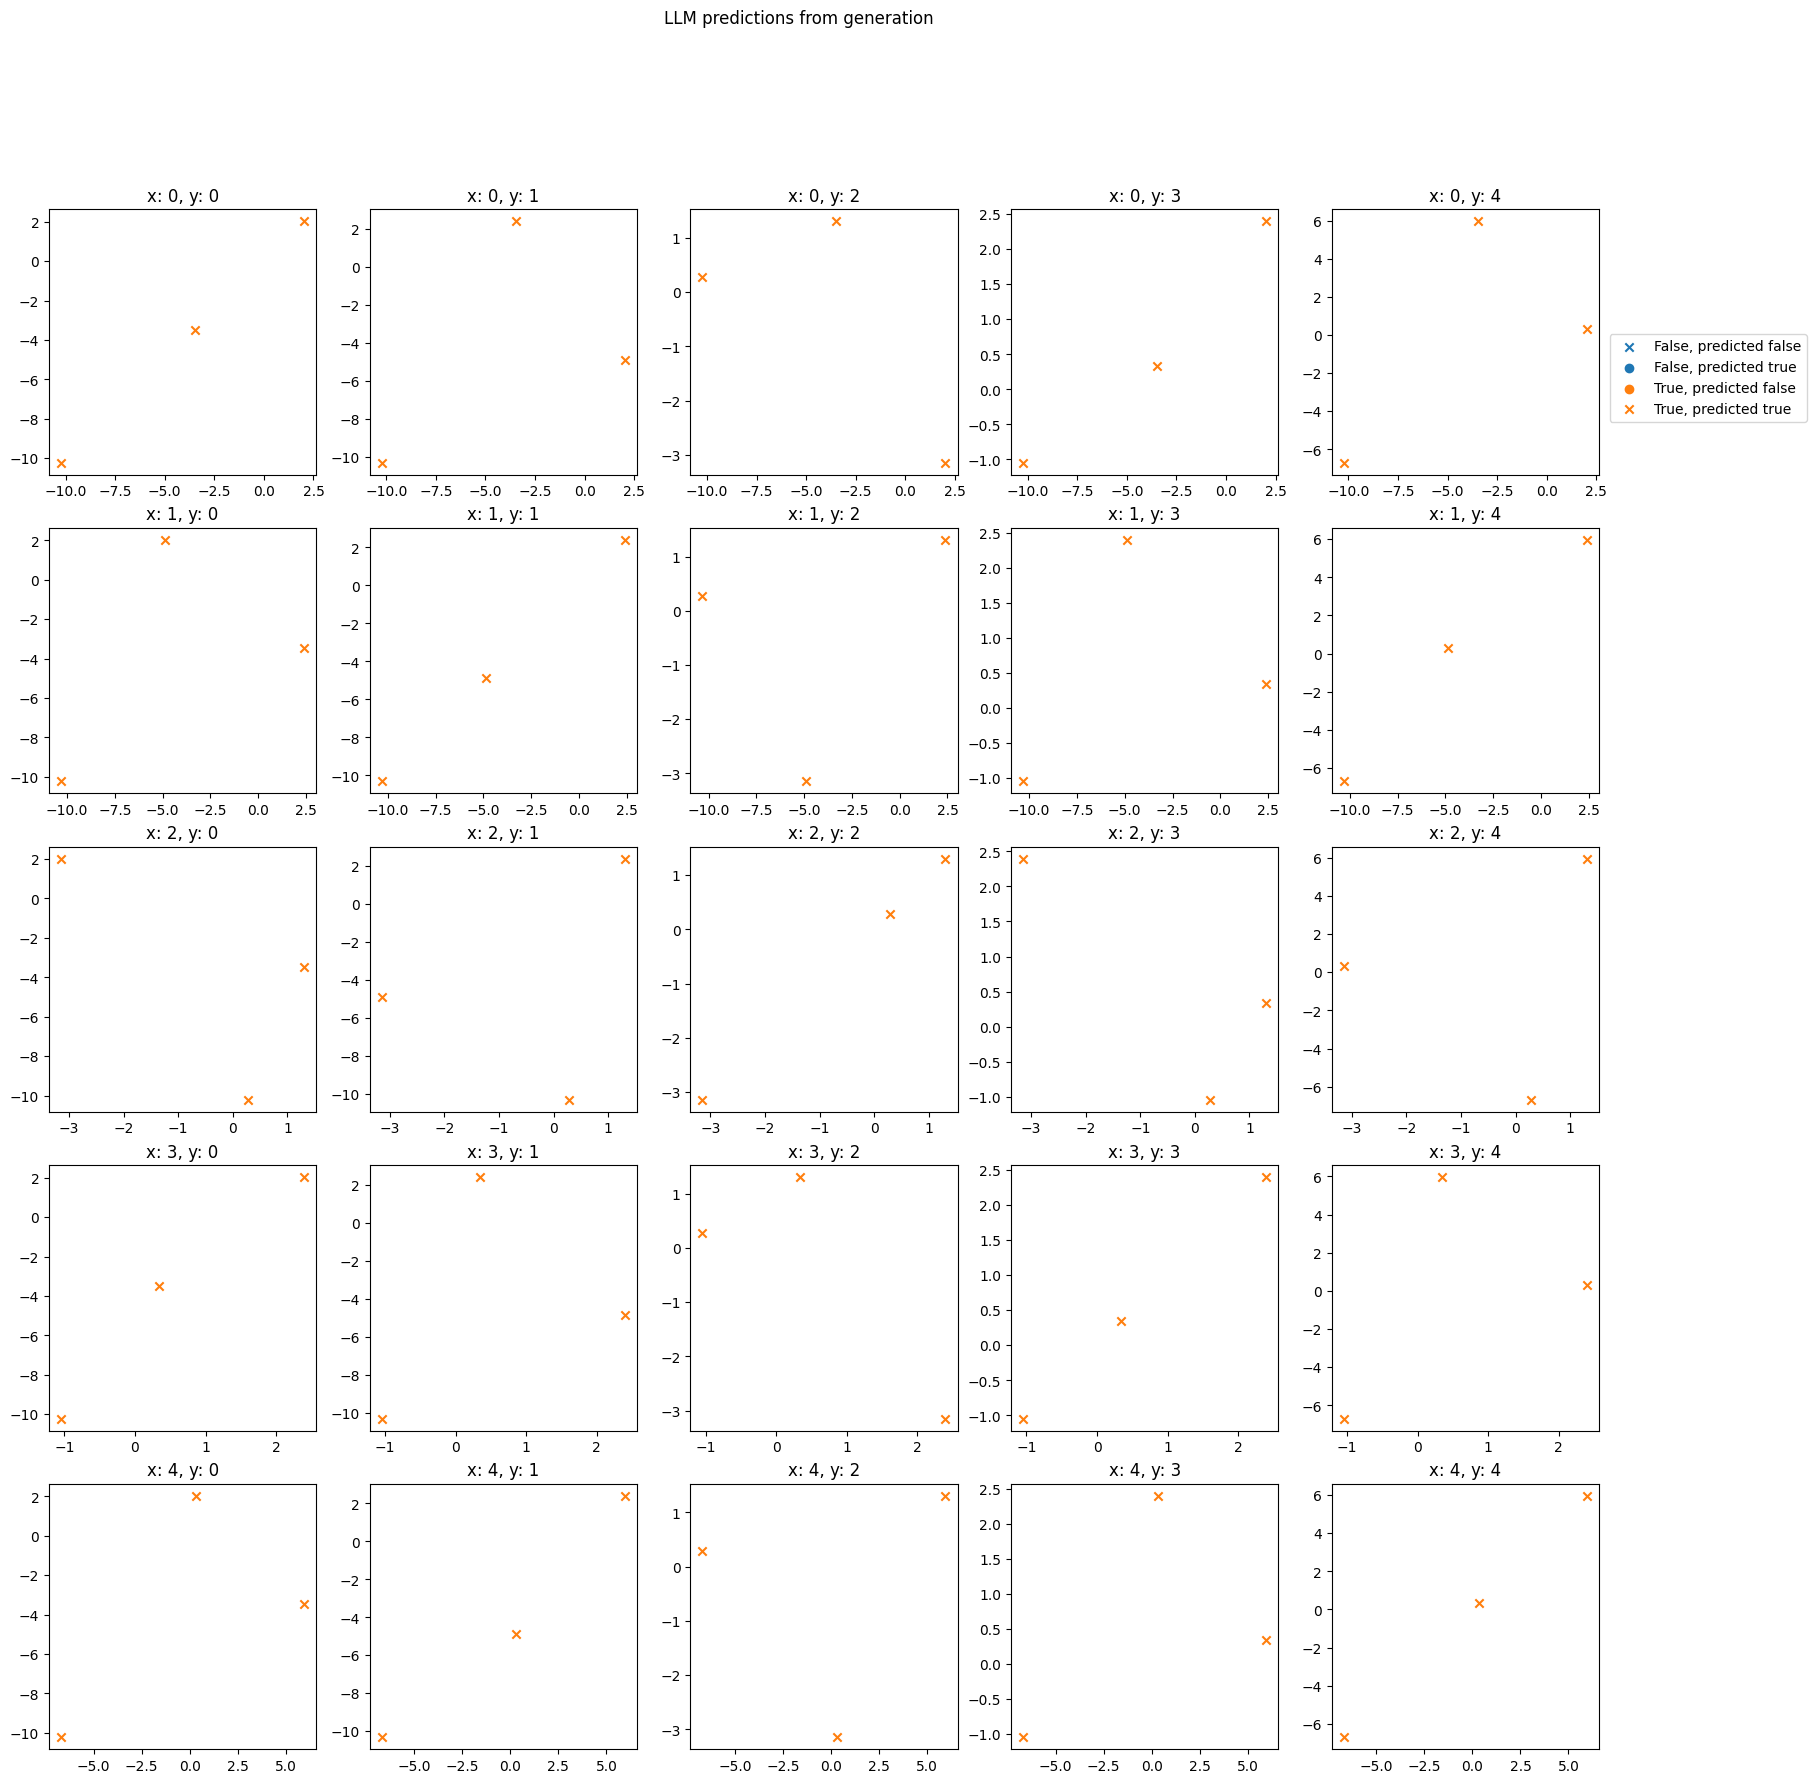

Dataset                      Model  \
0                   cities_prepared_experiment_1  meta-llama/Llama-2-13b-hf   
1  common_claim_true_false_prepared_experiment_1  meta-llama/Llama-2-13b-hf   
2   counterfact_true_false_prepared_experiment_1  meta-llama/Llama-2-13b-hf   

    Yes/No CL Linear probe accuracy   Generation  Generation baseline  \
0  [75%, 89%]           [95%, 100%]  [86%, 100%]                1.000   
1  [53%, 72%]            [44%, 64%]   [43%, 80%]                0.625   
2  [56%, 75%]            [41%, 61%]  [46%, 100%]                1.000   

     Rejects  
0  83 of 100  
1  76 of 100  
2  97 of 100

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Total price of evaluation: $0.05085450000000002


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

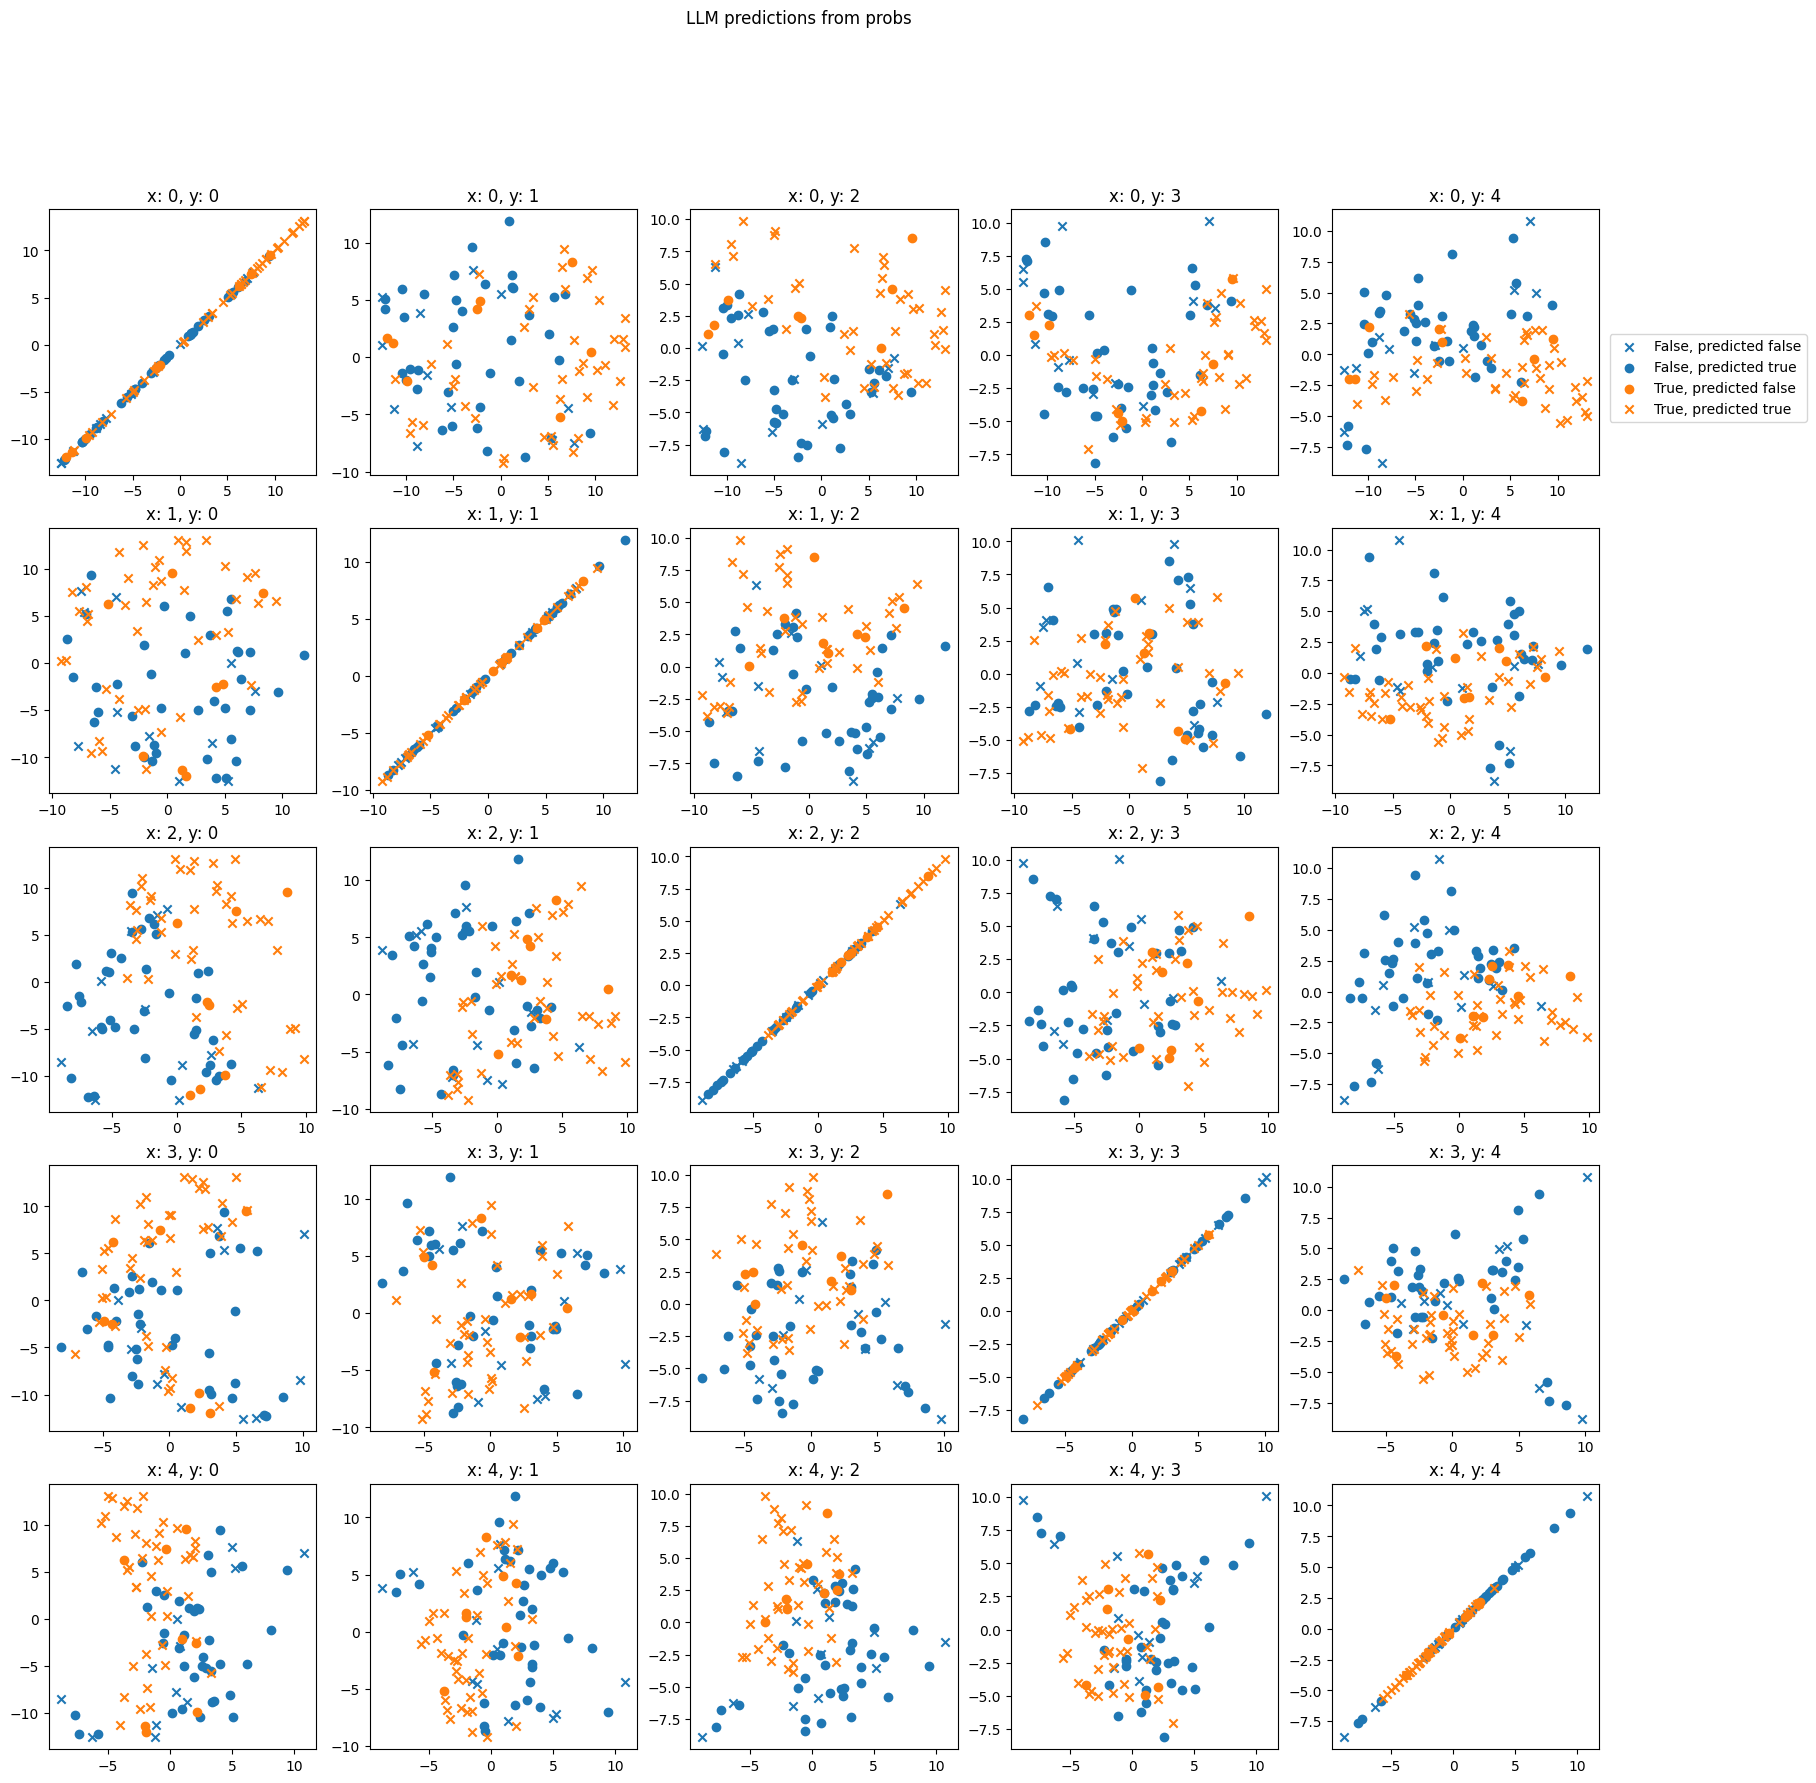

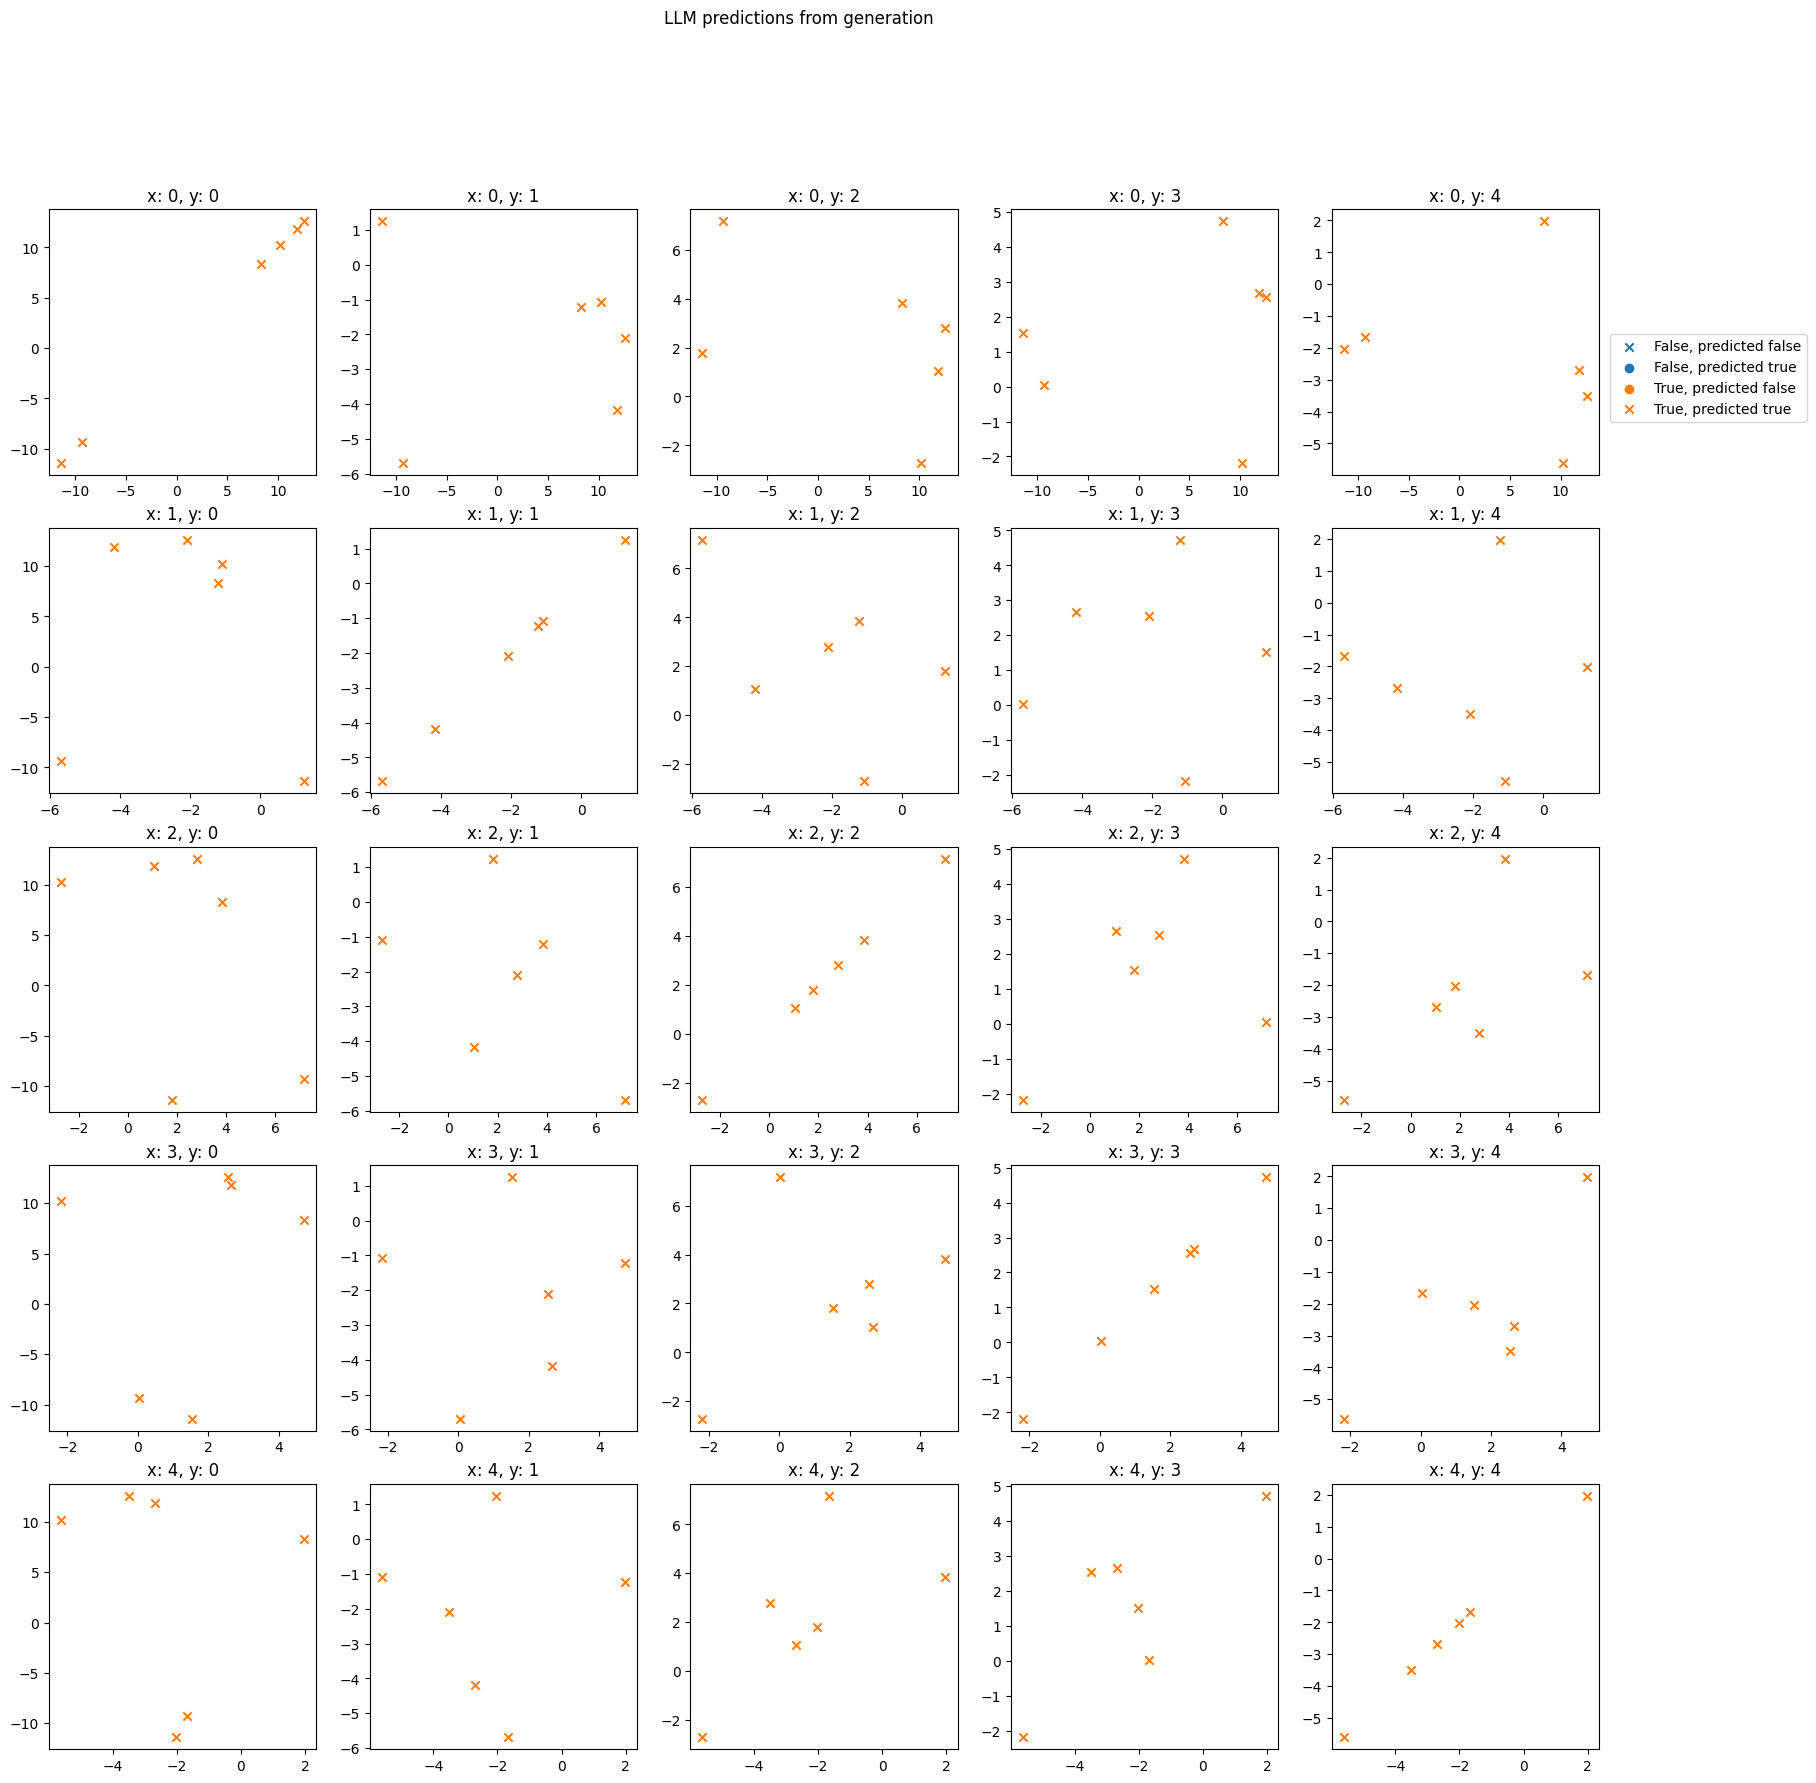

Dataset                      Model  \
0                   cities_prepared_experiment_1  meta-llama/Llama-2-13b-hf   
1  common_claim_true_false_prepared_experiment_1  meta-llama/Llama-2-13b-hf   
2   counterfact_true_false_prepared_experiment_1  meta-llama/Llama-2-13b-hf   
3                                    Politicians  meta-llama/Llama-2-13b-hf   

    Yes/No CL Linear probe accuracy   Generation  Generation baseline  \
0  [75%, 89%]           [95%, 100%]  [86%, 100%]                1.000   
1  [53%, 72%]            [44%, 64%]   [43%, 80%]                0.625   
2  [56%, 75%]            [41%, 61%]  [46%, 100%]                1.000   
3  [44%, 64%]            [65%, 82%]  [67%, 100%]                1.000   

     Rejects  
0  83 of 100  
1  76 of 100  
2  97 of 100  
3  94 of 100

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Datasets:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Total price of evaluation: $0.051015


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

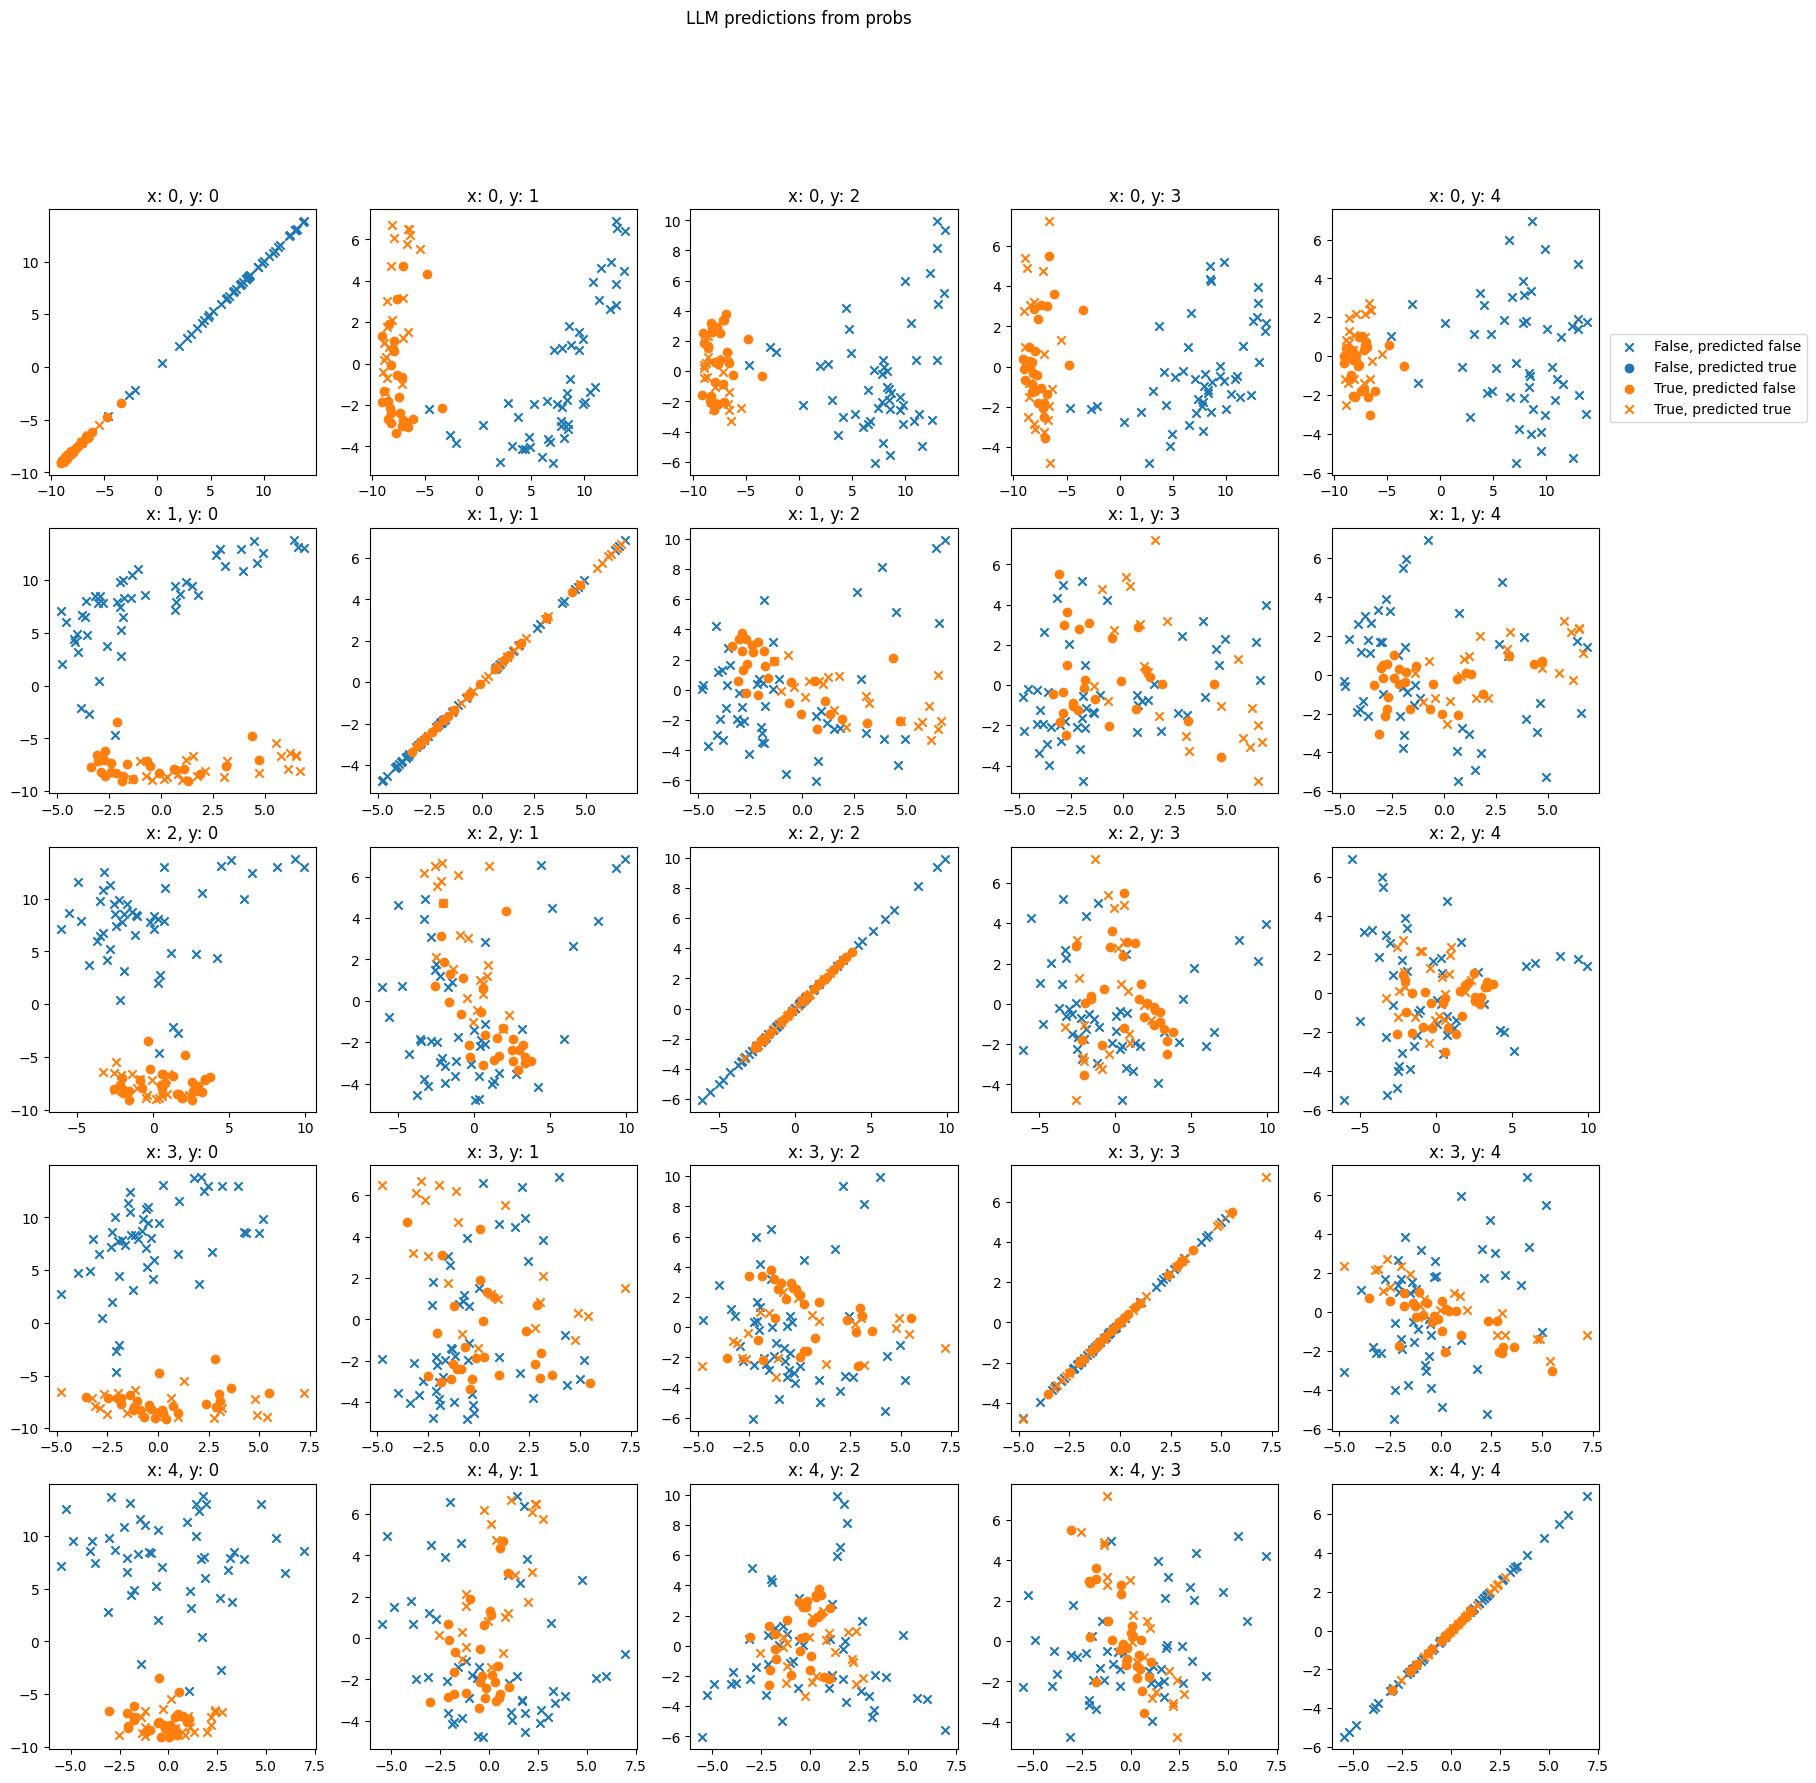

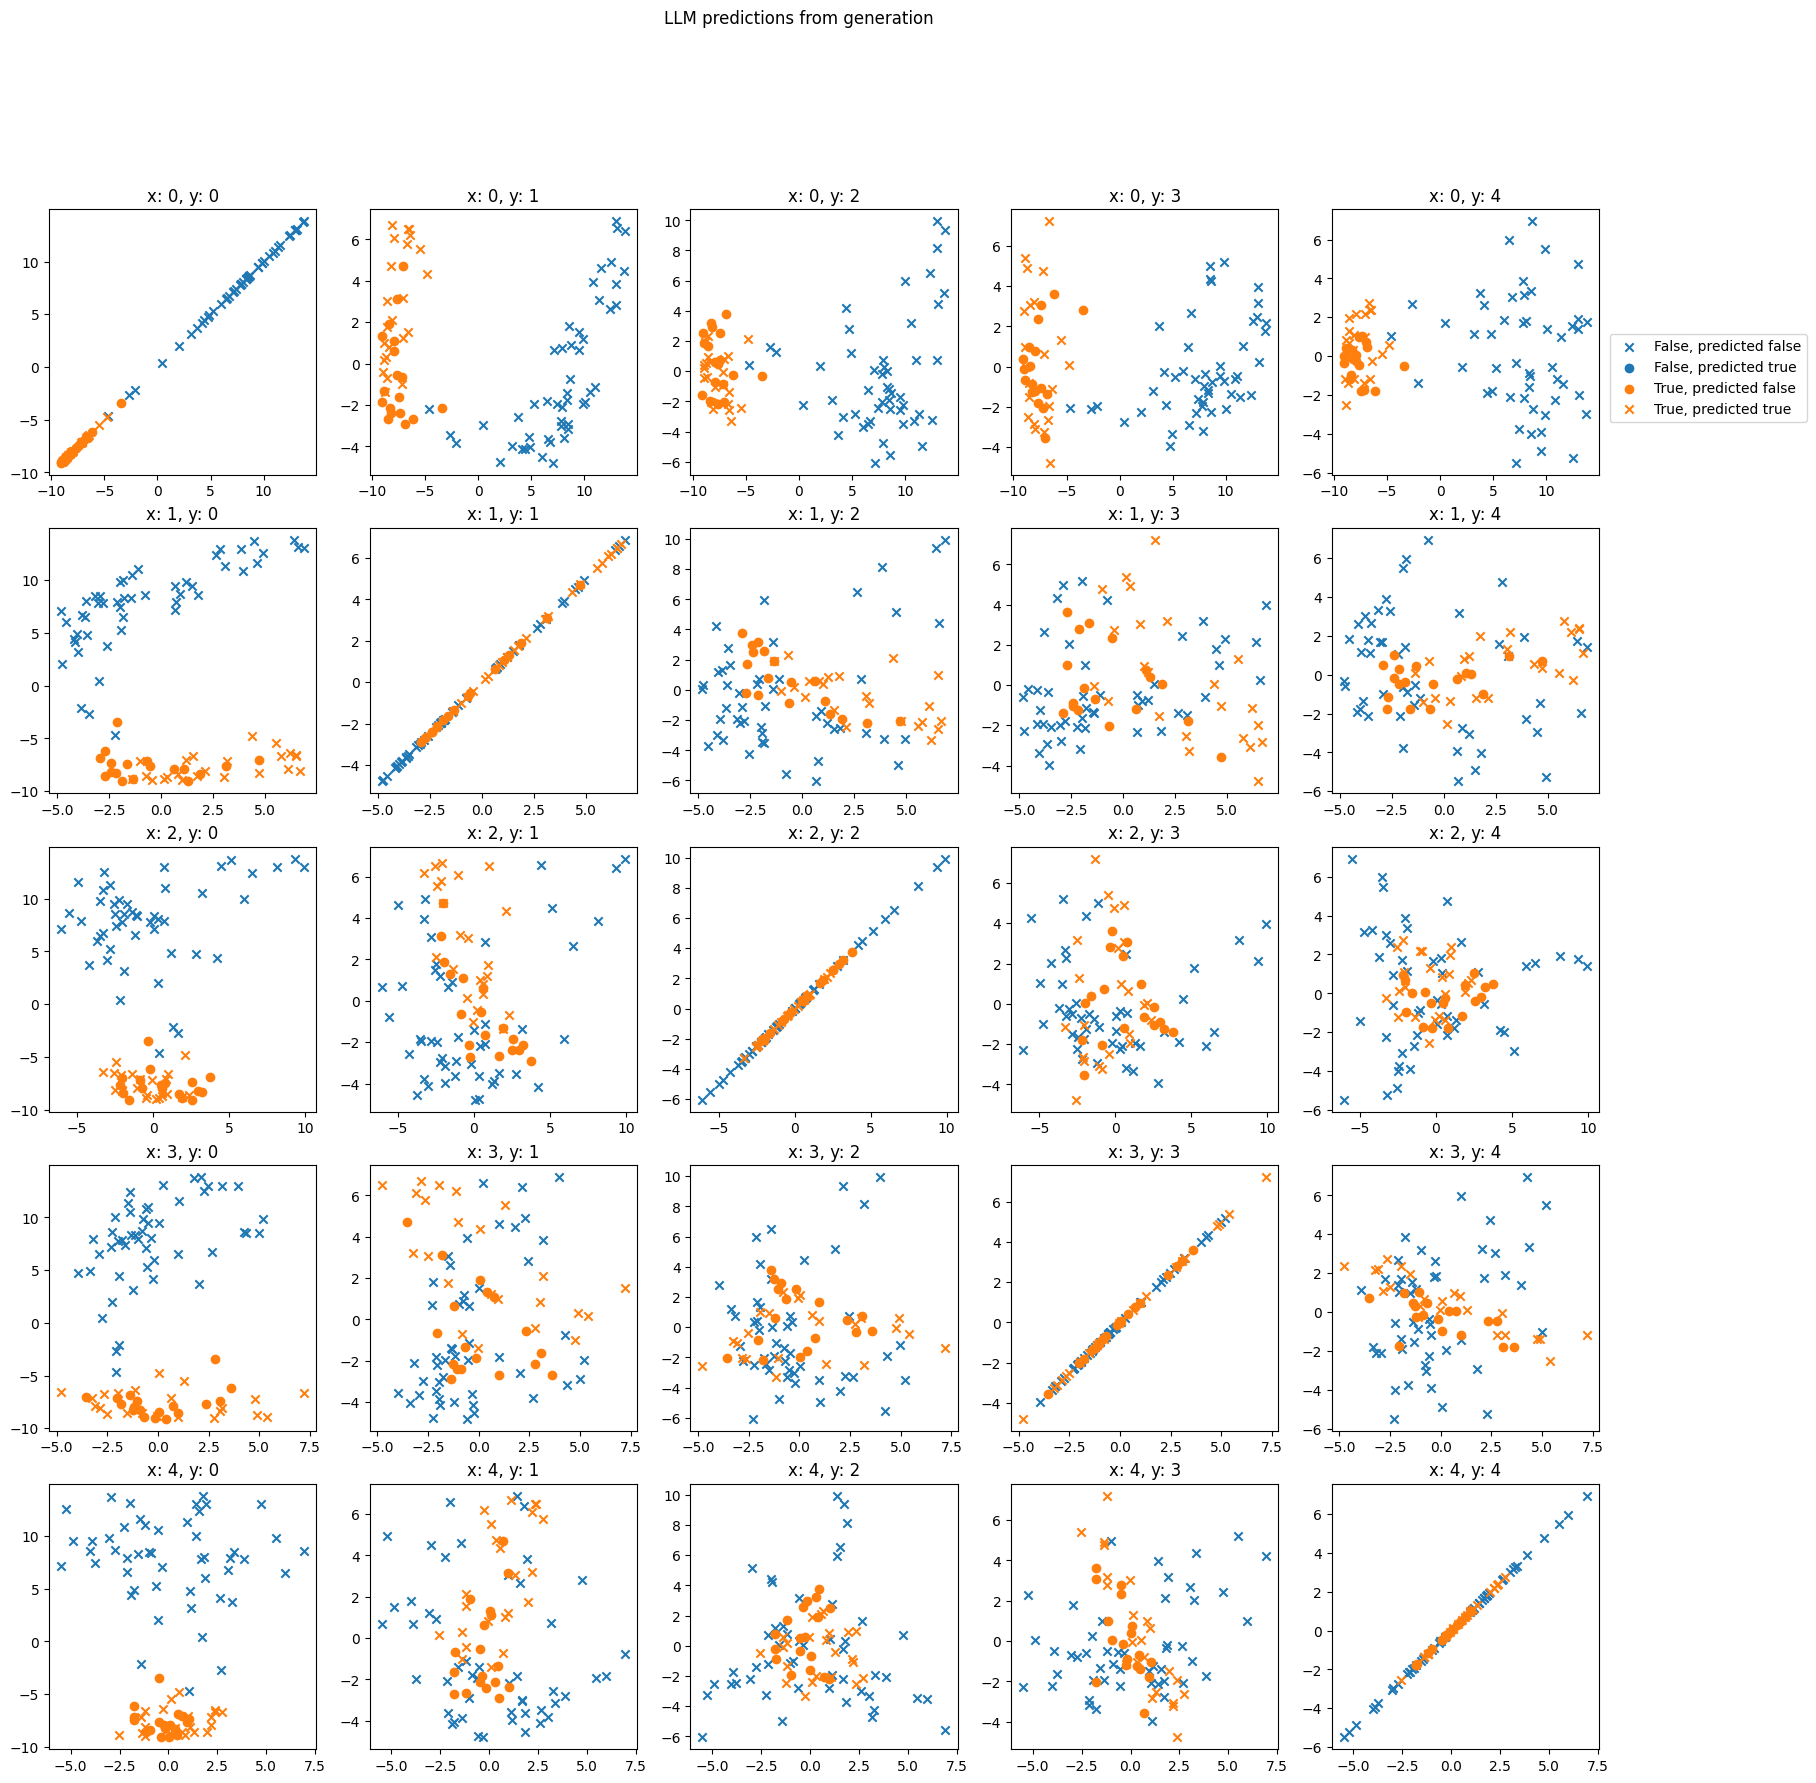

Dataset  \
0                   cities_prepared_experiment_1   
1  common_claim_true_false_prepared_experiment_1   
2   counterfact_true_false_prepared_experiment_1   
3                                    Politicians   
4                   cities_prepared_experiment_1   

                            Model   Yes/No CL Linear probe accuracy  \
0       meta-llama/Llama-2-13b-hf  [75%, 89%]           [95%, 100%]   
1       meta-llama/Llama-2-13b-hf  [53%, 72%]            [44%, 64%]   
2       meta-llama/Llama-2-13b-hf  [56%, 75%]            [41%, 61%]   
3       meta-llama/Llama-2-13b-hf  [44%, 64%]            [65%, 82%]   
4  meta-llama/Llama-2-13b-chat-hf  [63%, 80%]           [94%, 100%]   

    Generation  Generation baseline    Rejects  
0  [86%, 100%]             1.000000  83 of 100  
1   [43%, 80%]             0.625000  76 of 100  
2  [46%, 100%]             1.000000  97 of 100  
3  [67%, 100%]             1.000000  94 of 100  
4   [71%, 87%]             0.544444  10 of 100

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Total price of evaluation: $0.0529605


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

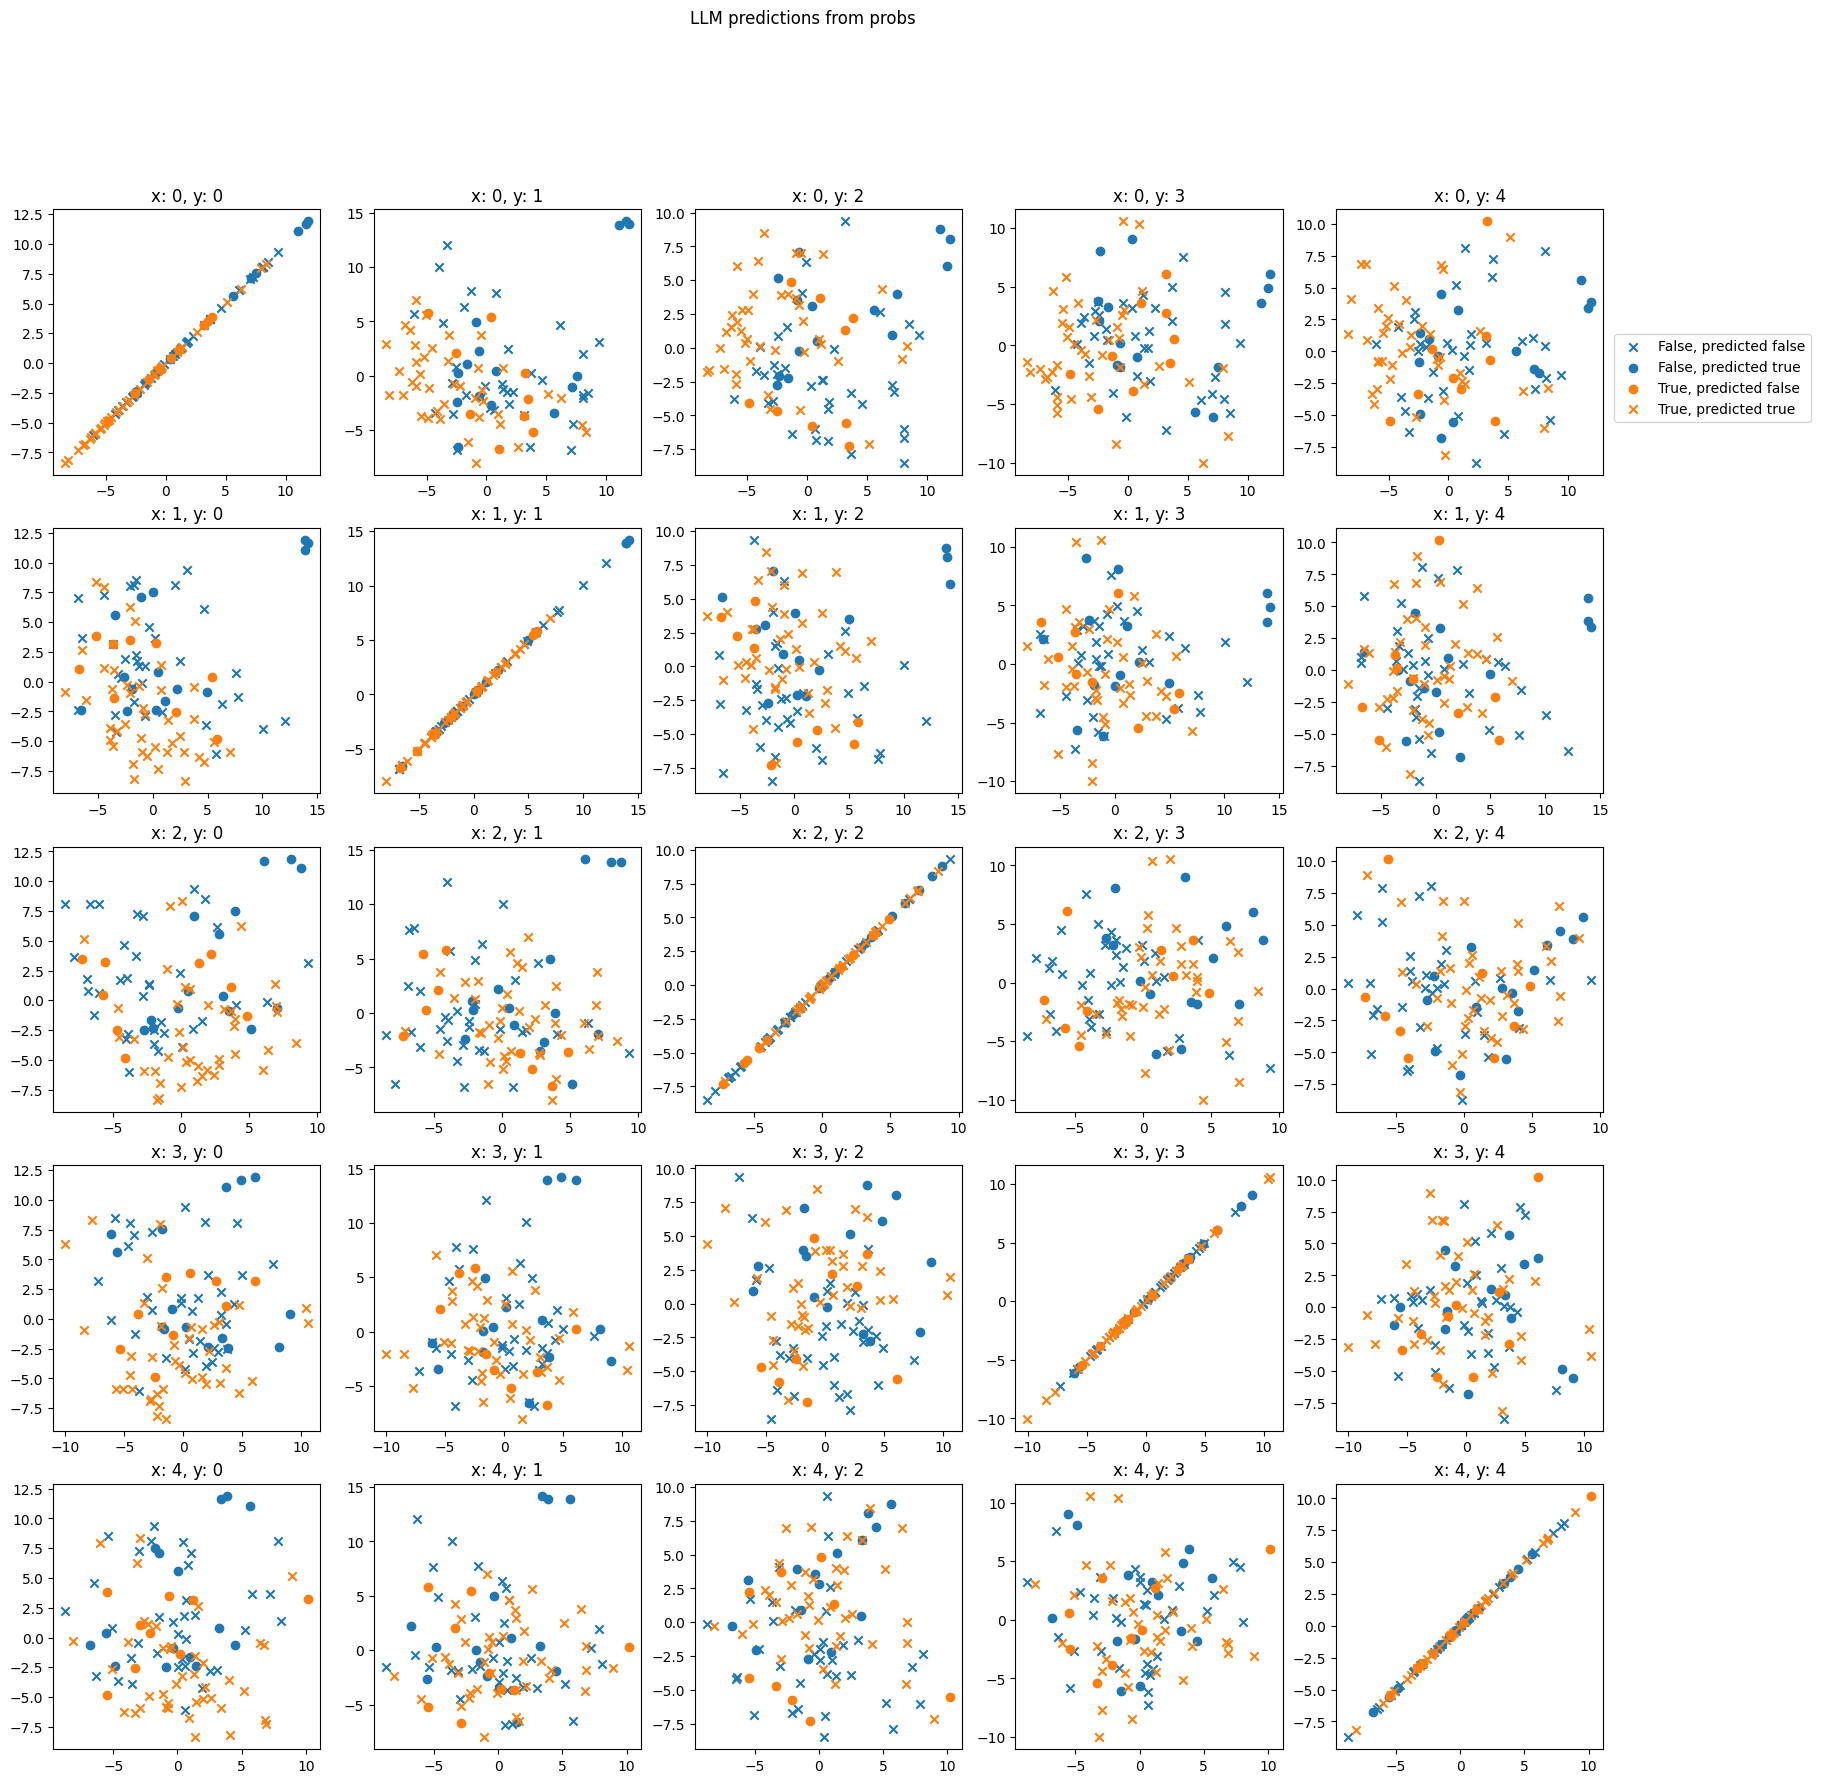

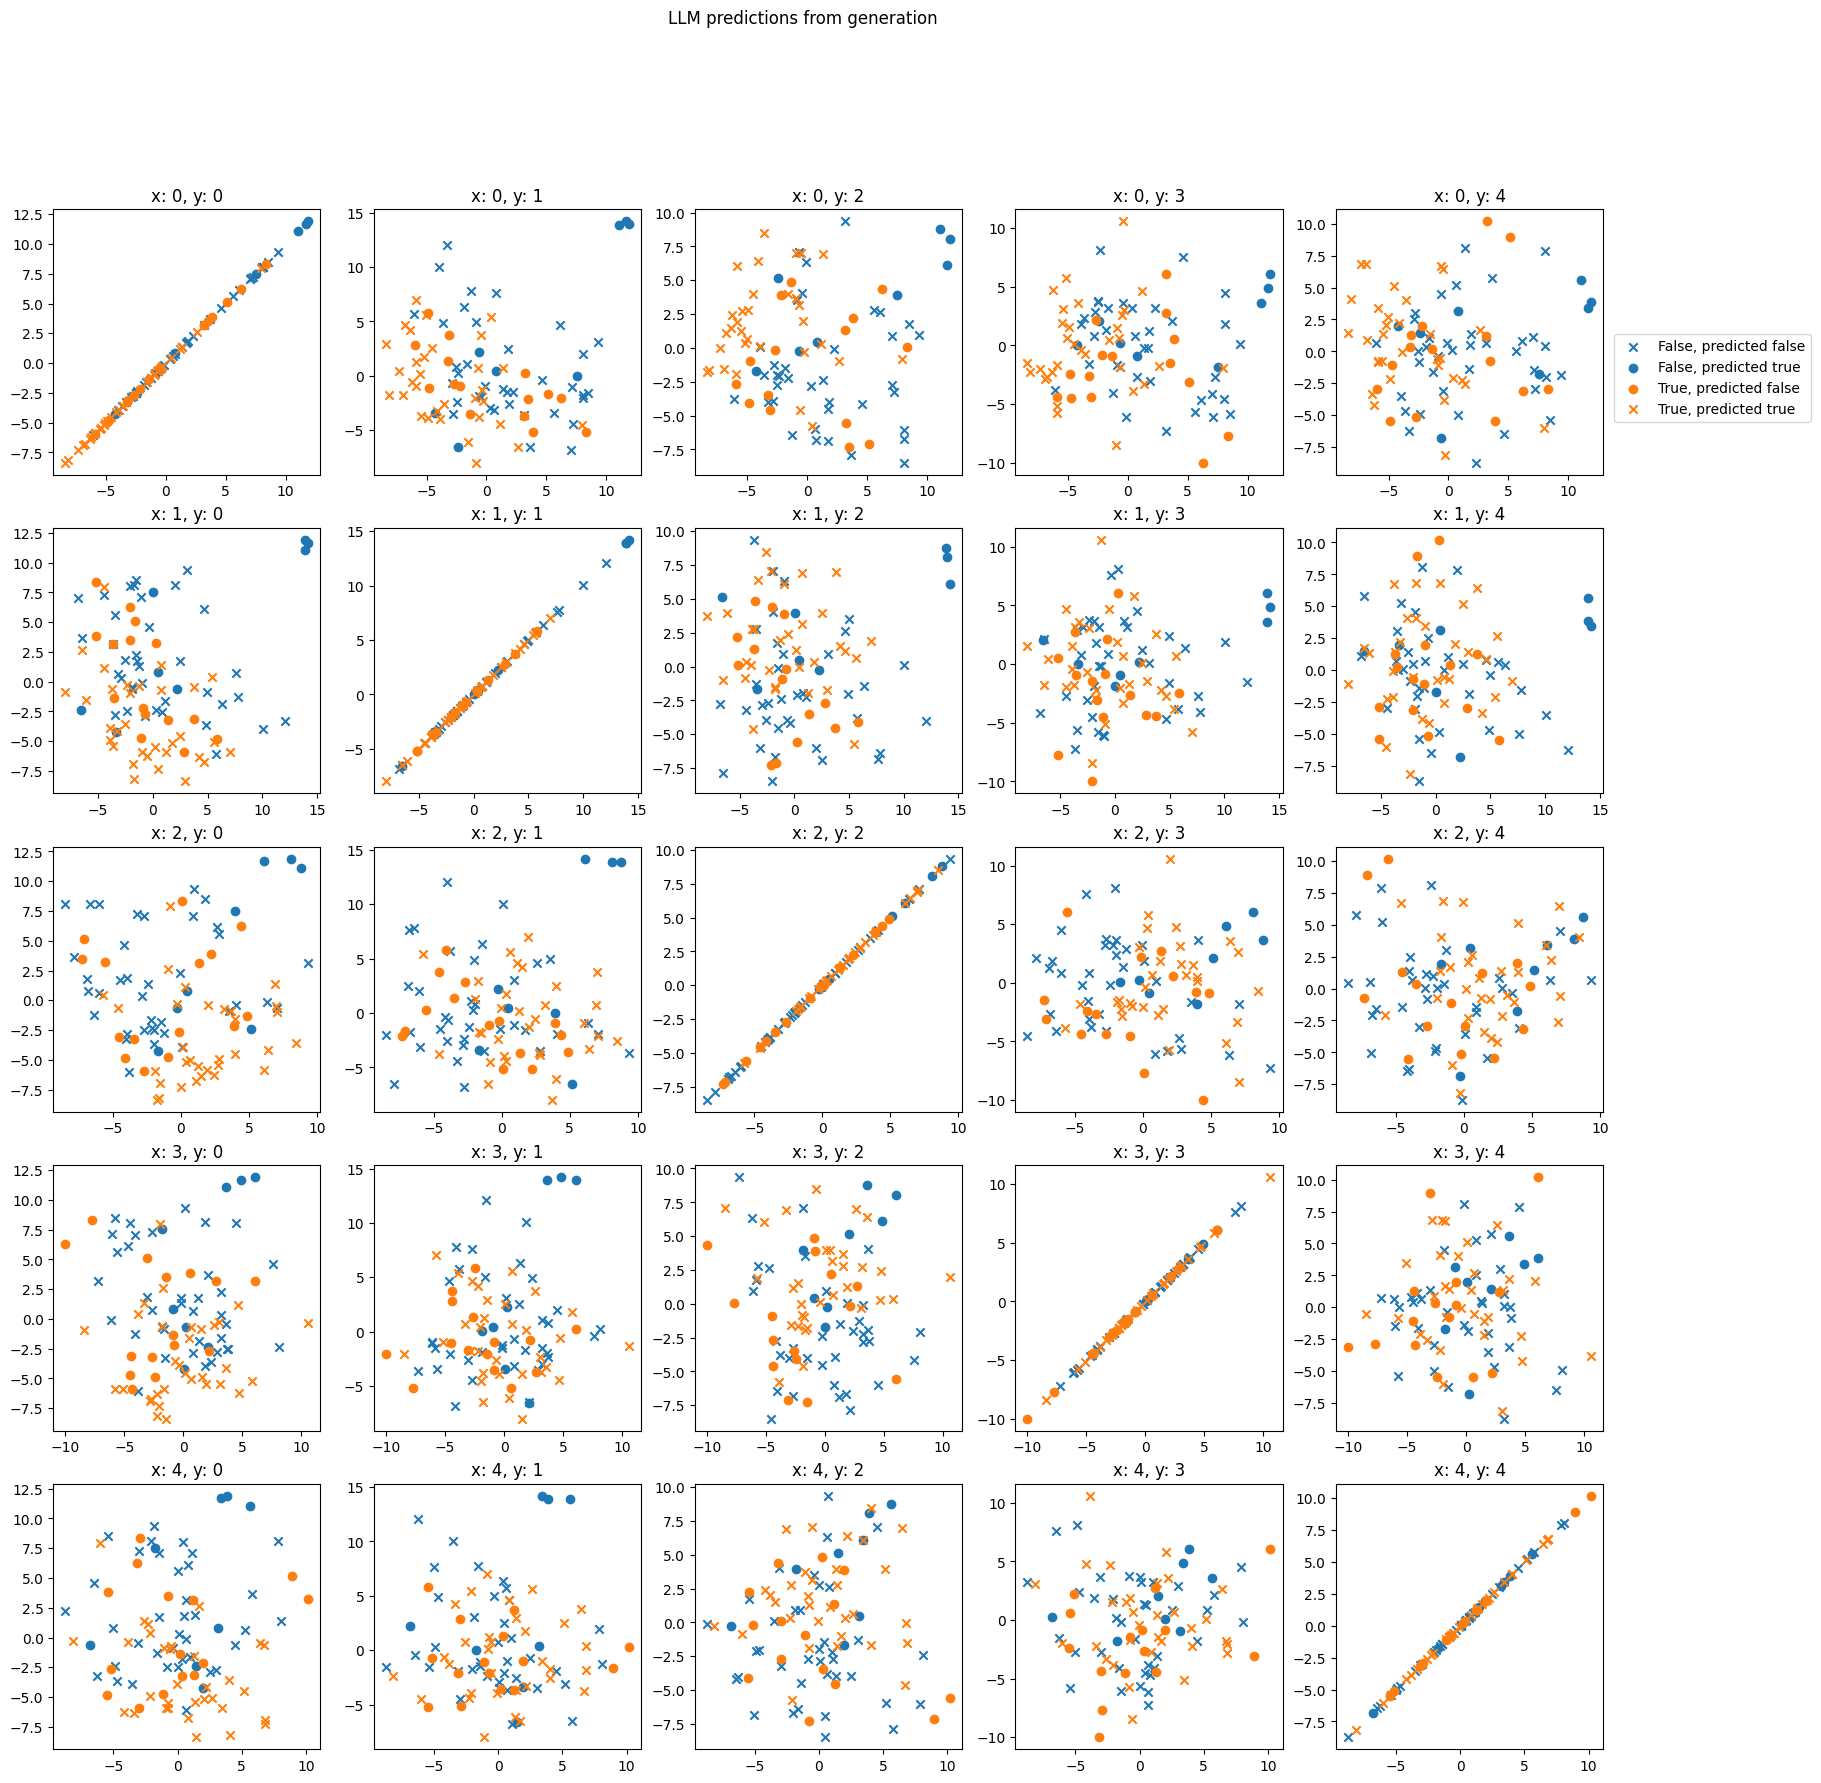

Dataset  \
0                   cities_prepared_experiment_1   
1  common_claim_true_false_prepared_experiment_1   
2   counterfact_true_false_prepared_experiment_1   
3                                    Politicians   
4                   cities_prepared_experiment_1   
5  common_claim_true_false_prepared_experiment_1   

                            Model   Yes/No CL Linear probe accuracy  \
0       meta-llama/Llama-2-13b-hf  [75%, 89%]           [95%, 100%]   
1       meta-llama/Llama-2-13b-hf  [53%, 72%]            [44%, 64%]   
2       meta-llama/Llama-2-13b-hf  [56%, 75%]            [41%, 61%]   
3       meta-llama/Llama-2-13b-hf  [44%, 64%]            [65%, 82%]   
4  meta-llama/Llama-2-13b-chat-hf  [63%, 80%]           [94%, 100%]   
5  meta-llama/Llama-2-13b-chat-hf  [67%, 84%]            [39%, 59%]   

    Generation  Generation baseline    Rejects  
0  [86%, 100%]             1.000000  83 of 100  
1   [43%, 80%]             0.625000  76 of 100  
2  [46%, 100%]             1.000000  97 of 100  
3  [67%, 100%]             1.000000  94 of 100  
4   [71%, 87%]             0.544444  10 of 100  
5   [65%, 83%]             0.510870   8 of 100

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Total price of evaluation: $0.052531499999999974


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

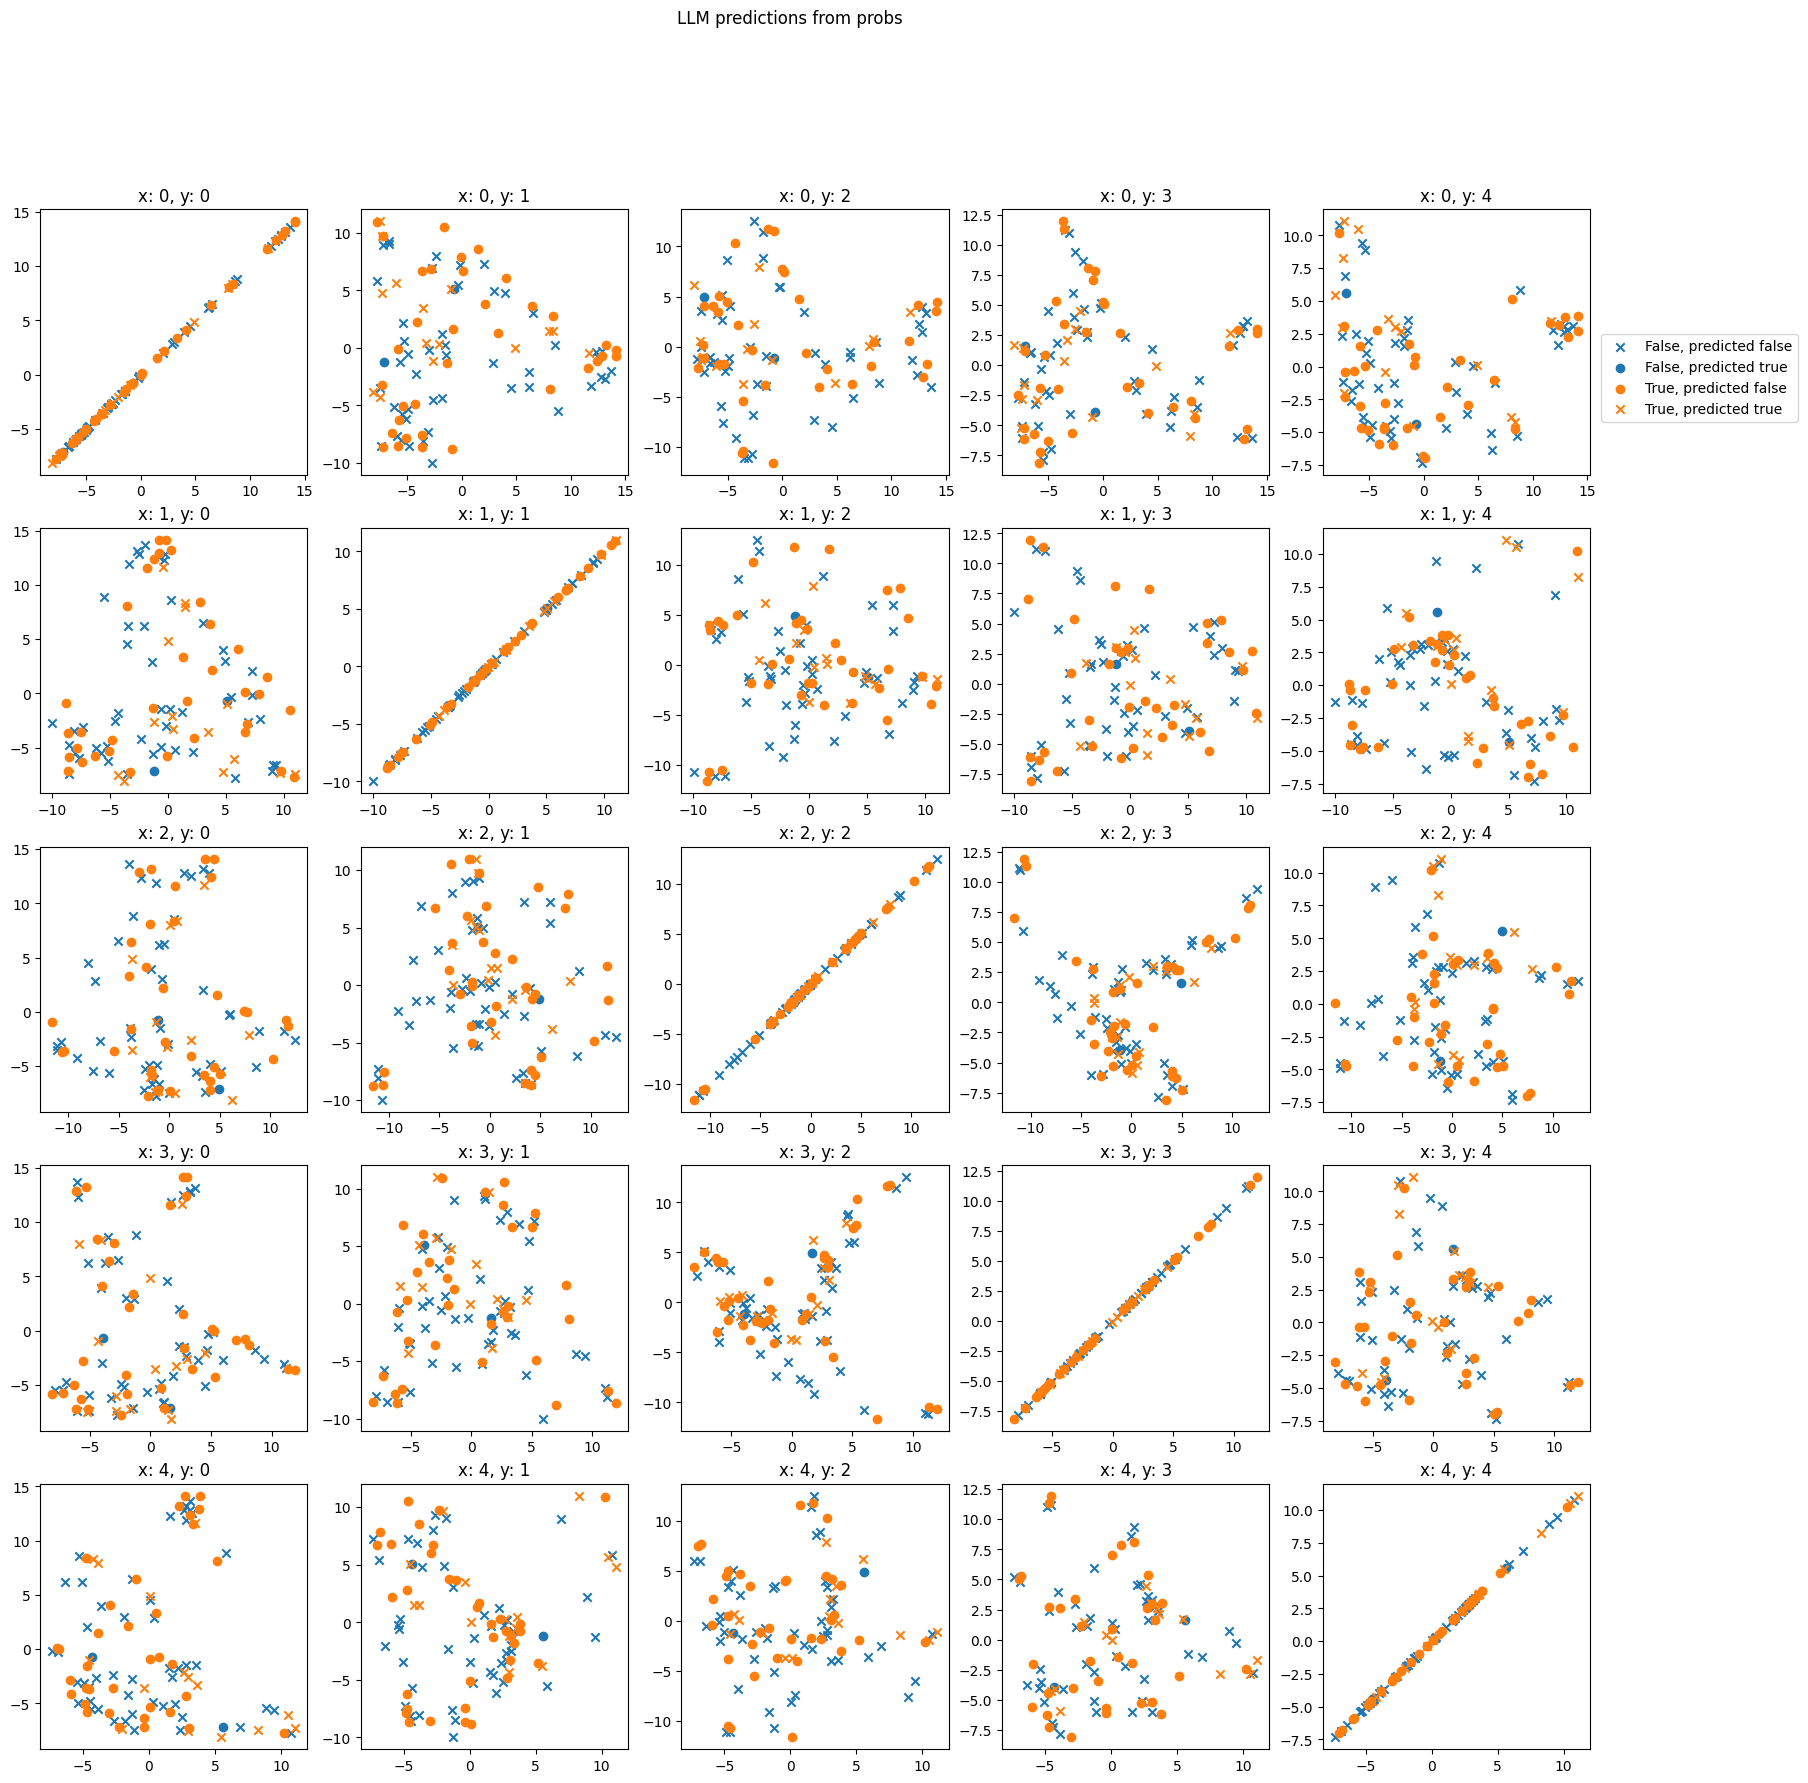

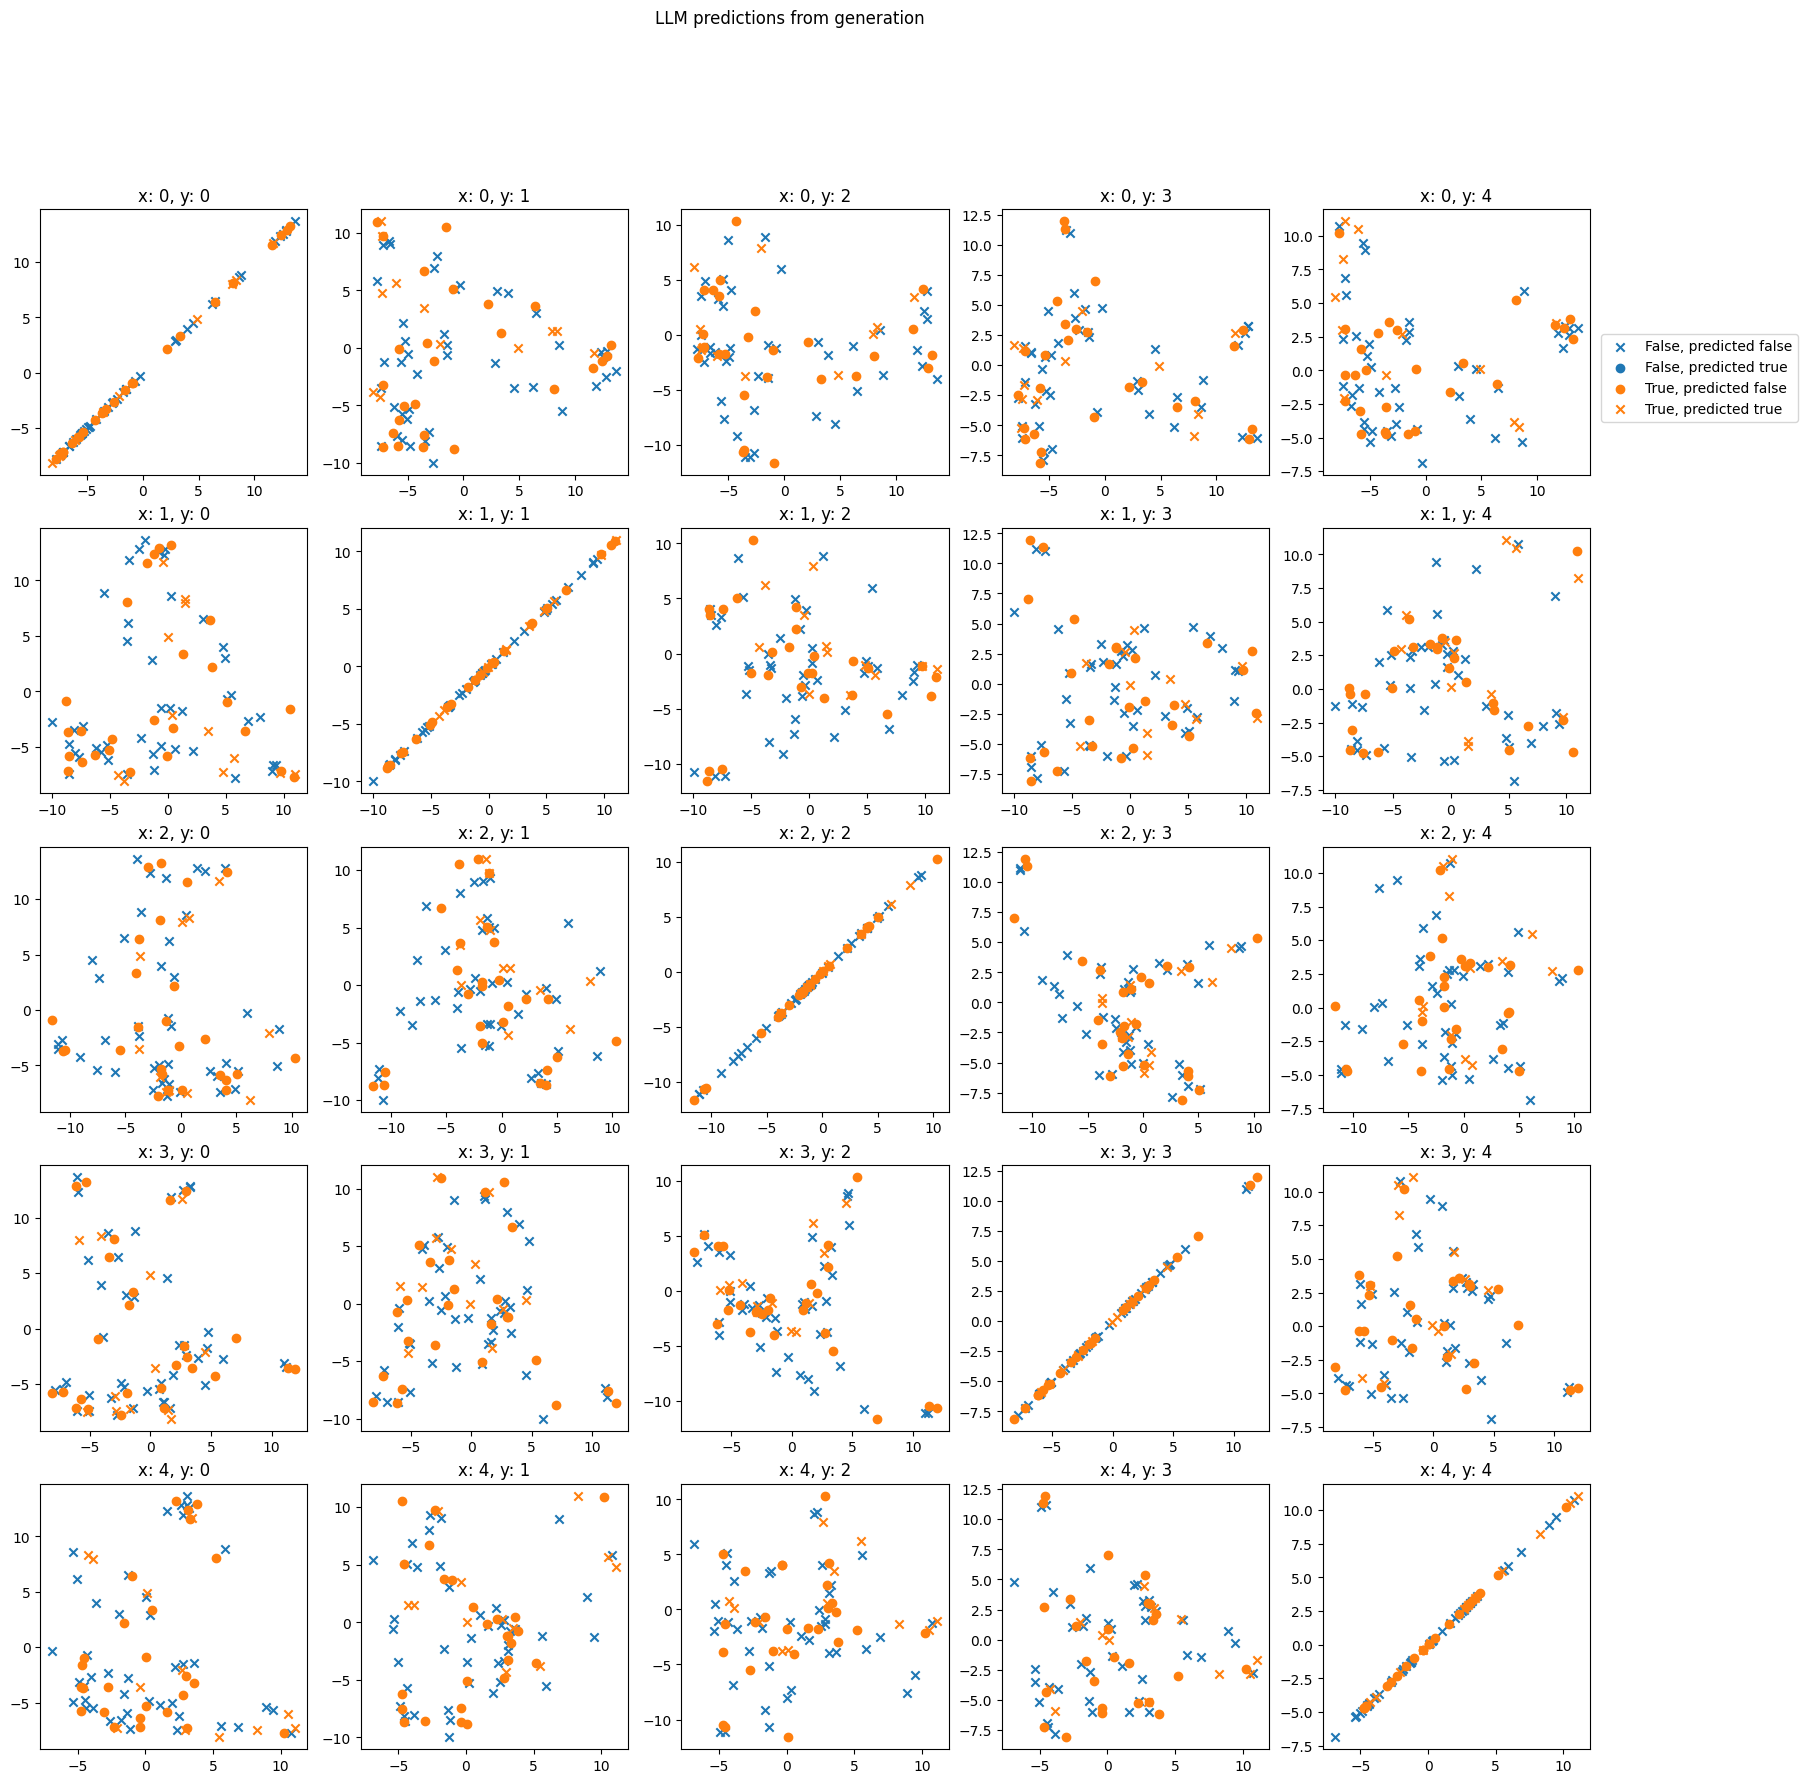

Dataset  \
0                   cities_prepared_experiment_1   
1  common_claim_true_false_prepared_experiment_1   
2   counterfact_true_false_prepared_experiment_1   
3                                    Politicians   
4                   cities_prepared_experiment_1   
5  common_claim_true_false_prepared_experiment_1   
6   counterfact_true_false_prepared_experiment_1   

                            Model   Yes/No CL Linear probe accuracy  \
0       meta-llama/Llama-2-13b-hf  [75%, 89%]           [95%, 100%]   
1       meta-llama/Llama-2-13b-hf  [53%, 72%]            [44%, 64%]   
2       meta-llama/Llama-2-13b-hf  [56%, 75%]            [41%, 61%]   
3       meta-llama/Llama-2-13b-hf  [44%, 64%]            [65%, 82%]   
4  meta-llama/Llama-2-13b-chat-hf  [63%, 80%]           [94%, 100%]   
5  meta-llama/Llama-2-13b-chat-hf  [67%, 84%]            [39%, 59%]   
6  meta-llama/Llama-2-13b-chat-hf  [53%, 72%]            [50%, 69%]   

    Generation  Generation baseline    Rejects  
0  [86%, 100%]             1.000000  83 of 100  
1   [43%, 80%]             0.625000  76 of 100  
2  [46%, 100%]             1.000000  97 of 100  
3  [67%, 100%]             1.000000  94 of 100  
4   [71%, 87%]             0.544444  10 of 100  
5   [65%, 83%]             0.510870   8 of 100  
6   [57%, 77%]             0.530864  19 of 100

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Total price of evaluation: $0.05168850000000001


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

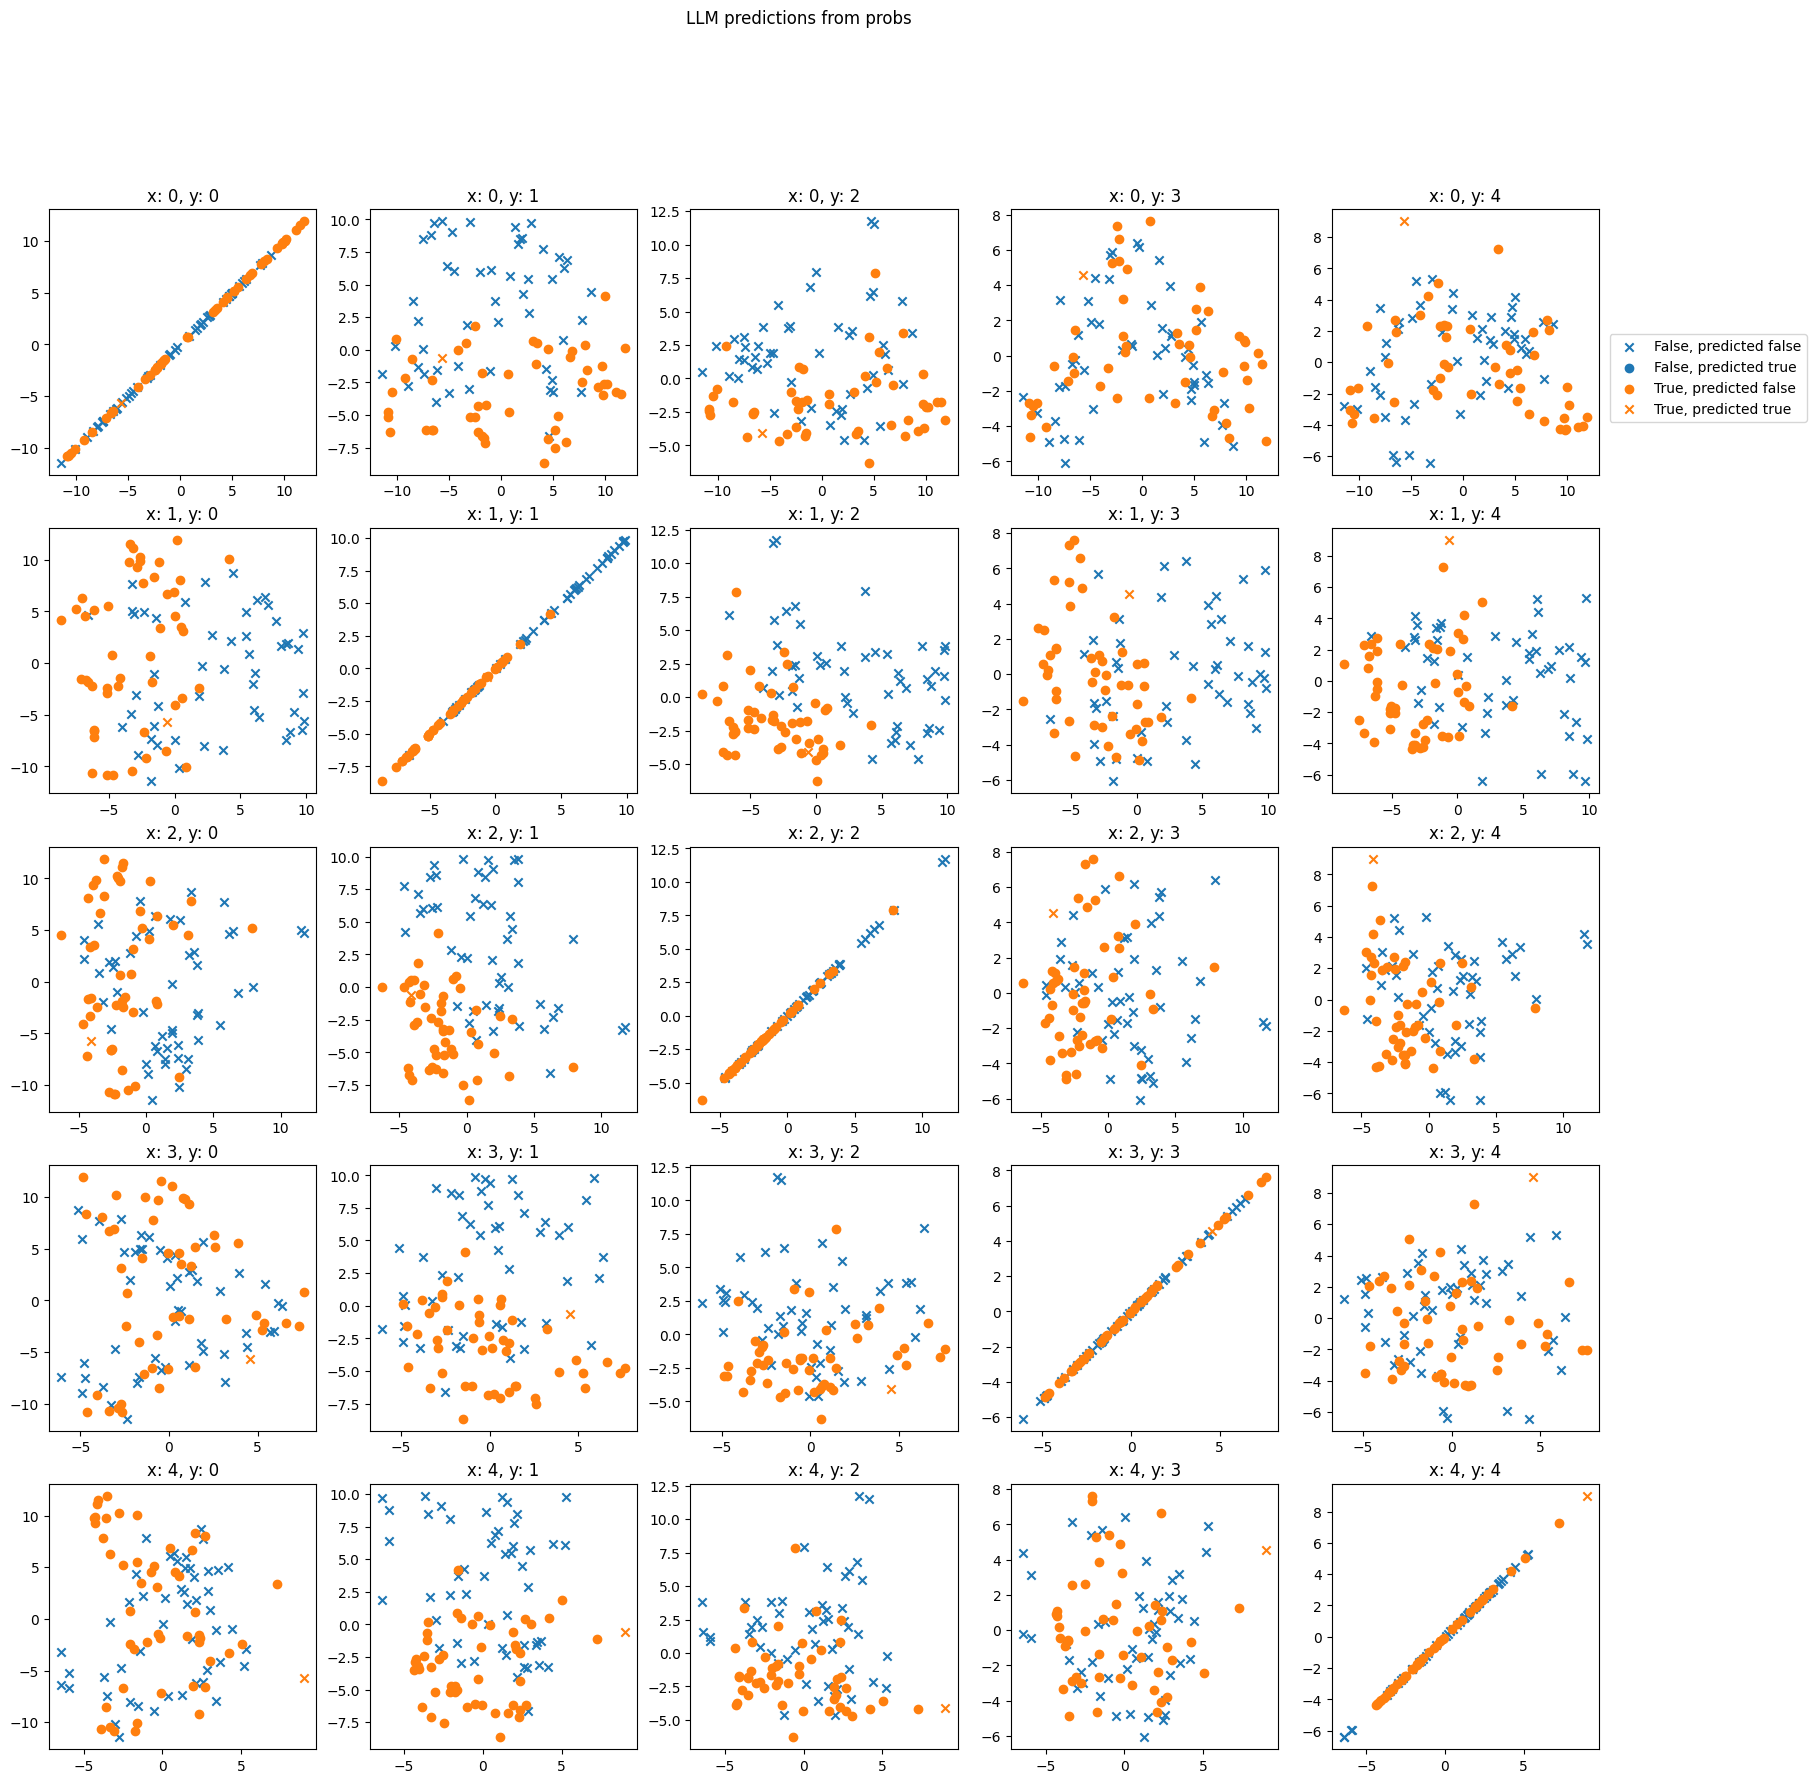

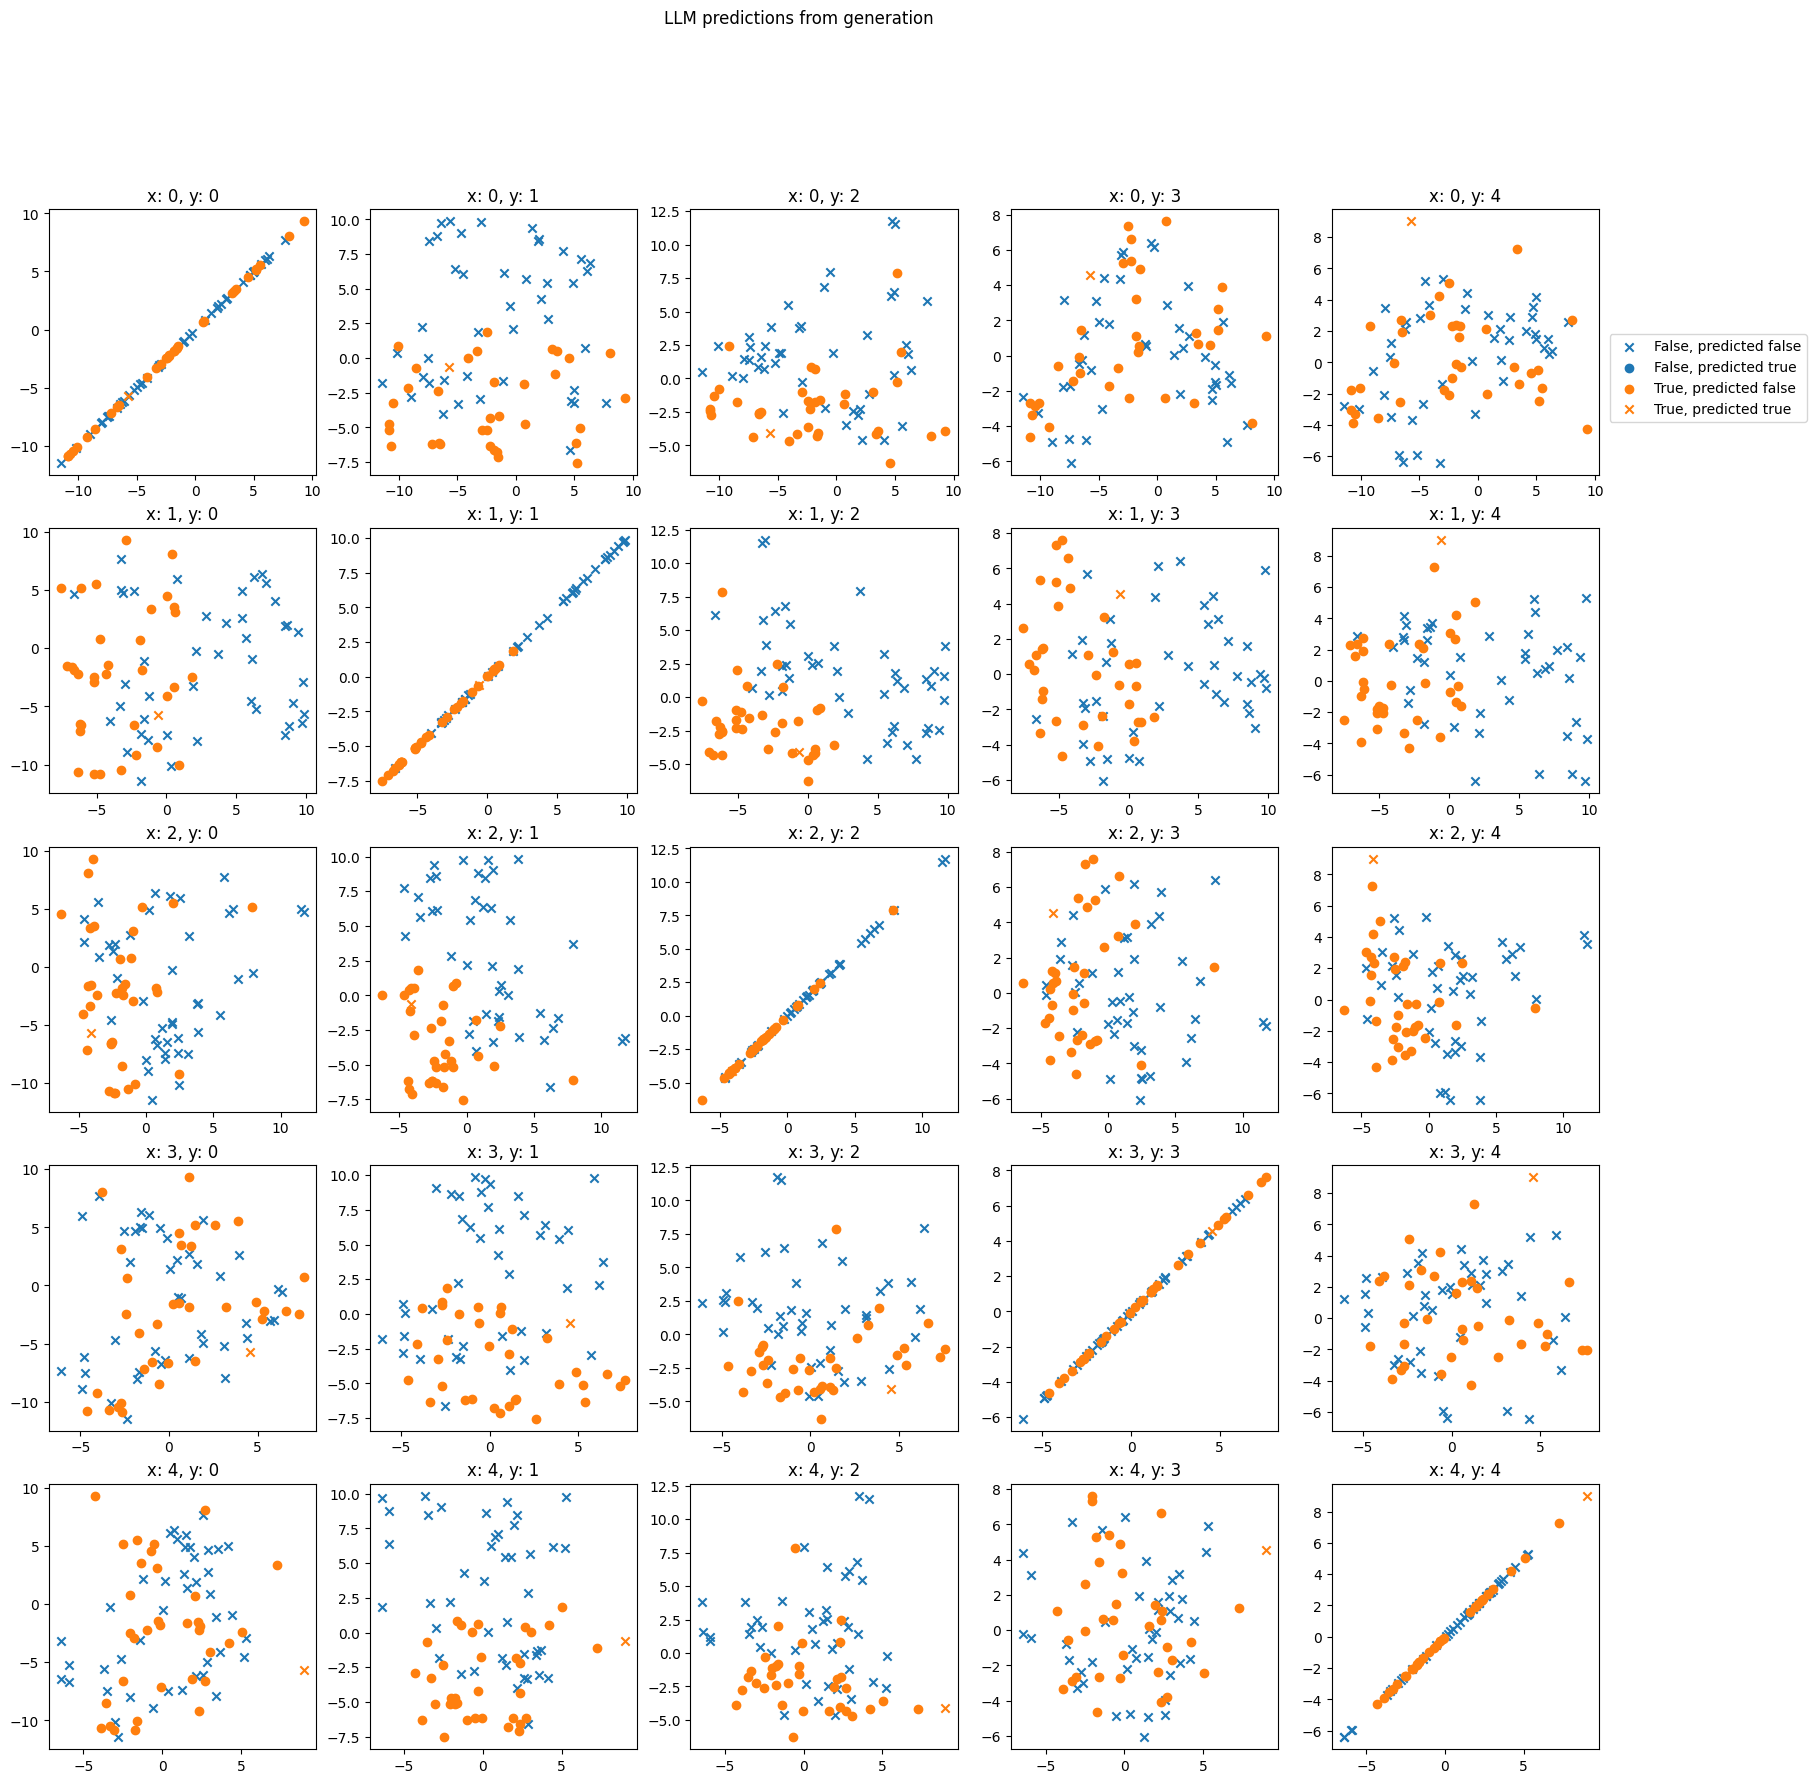

Dataset  \
0                   cities_prepared_experiment_1   
1  common_claim_true_false_prepared_experiment_1   
2   counterfact_true_false_prepared_experiment_1   
3                                    Politicians   
4                   cities_prepared_experiment_1   
5  common_claim_true_false_prepared_experiment_1   
6   counterfact_true_false_prepared_experiment_1   
7                                    Politicians   

                            Model   Yes/No CL Linear probe accuracy  \
0       meta-llama/Llama-2-13b-hf  [75%, 89%]           [95%, 100%]   
1       meta-llama/Llama-2-13b-hf  [53%, 72%]            [44%, 64%]   
2       meta-llama/Llama-2-13b-hf  [56%, 75%]            [41%, 61%]   
3       meta-llama/Llama-2-13b-hf  [44%, 64%]            [65%, 82%]   
4  meta-llama/Llama-2-13b-chat-hf  [63%, 80%]           [94%, 100%]   
5  meta-llama/Llama-2-13b-chat-hf  [67%, 84%]            [39%, 59%]   
6  meta-llama/Llama-2-13b-chat-hf  [53%, 72%]            [50%, 69%]   
7  meta-llama/Llama-2-13b-chat-hf  [41%, 61%]            [66%, 83%]   

    Generation  Generation baseline    Rejects  
0  [86%, 100%]             1.000000  83 of 100  
1   [43%, 80%]             0.625000  76 of 100  
2  [46%, 100%]             1.000000  97 of 100  
3  [67%, 100%]             1.000000  94 of 100  
4   [71%, 87%]             0.544444  10 of 100  
5   [65%, 83%]             0.510870   8 of 100  
6   [57%, 77%]             0.530864  19 of 100  
7   [45%, 67%]             0.551282  22 of 100

Dataset  \
0                   cities_prepared_experiment_1   
1  common_claim_true_false_prepared_experiment_1   
2   counterfact_true_false_prepared_experiment_1   
3                                    Politicians   
4                   cities_prepared_experiment_1   
5  common_claim_true_false_prepared_experiment_1   
6   counterfact_true_false_prepared_experiment_1   
7                                    Politicians   

                            Model   Yes/No CL Linear probe accuracy  \
0       meta-llama/Llama-2-13b-hf  [75%, 89%]           [95%, 100%]   
1       meta-llama/Llama-2-13b-hf  [53%, 72%]            [44%, 64%]   
2       meta-llama/Llama-2-13b-hf  [56%, 75%]            [41%, 61%]   
3       meta-llama/Llama-2-13b-hf  [44%, 64%]            [65%, 82%]   
4  meta-llama/Llama-2-13b-chat-hf  [63%, 80%]           [94%, 100%]   
5  meta-llama/Llama-2-13b-chat-hf  [67%, 84%]            [39%, 59%]   
6  meta-llama/Llama-2-13b-chat-hf  [53%, 72%]            [50%, 69%]   
7  meta-llama/Llama-2-13b-chat-hf  [41%, 61%]            [66%, 83%]   

    Generation  Generation baseline    Rejects  
0  [86%, 100%]             1.000000  83 of 100  
1   [43%, 80%]             0.625000  76 of 100  
2  [46%, 100%]             1.000000  97 of 100  
3  [67%, 100%]             1.000000  94 of 100  
4   [71%, 87%]             0.544444  10 of 100  
5   [65%, 83%]             0.510870   8 of 100  
6   [57%, 77%]             0.530864  19 of 100  
7   [45%, 67%]             0.551282  22 of 100

In [17]:
from tqdm.notebook import tqdm
from IPython.display import display, clear_output

results_df = pd.DataFrame(columns=["Dataset", "Model", "Yes/No CL", "Linear probe accuracy", "Generation", "Generation baseline", "Rejects"])
i = 0
ds = []
probe_preds = []
cls = []
for model_name in tqdm(models, desc="Models", leave=False):
  model, tokenizer = load_model(model_name)
  for dataset_name, df_concat in tqdm(datasets, desc="Datasets", leave=False):
    results_df.loc[i], d, pp, cl = experiment(dataset_name, df_concat, model_name, model, tokenizer)
    ds.append(d)
    probe_preds.append(pp)
    cls.append(cl)
    i += 1
    display(results_df)

  import torch, gc
  model.cpu()
  del model
  torch.cuda.empty_cache()
  gc.collect()

results_df

In [18]:
print(results_df.to_latex())

\begin{tabular}{llllllrl}
\toprule
 & Dataset & Model & Yes/No CL & Linear probe accuracy & Generation & Generation baseline & Rejects \\
\midrule
0 & cities_prepared_experiment_1 & meta-llama/Llama-2-13b-hf & ['75%', '89%'] & ['95%', '100%'] & ['86%', '100%'] & 1.000000 & 83 of 100 \\
1 & common_claim_true_false_prepared_experiment_1 & meta-llama/Llama-2-13b-hf & ['53%', '72%'] & ['44%', '64%'] & ['43%', '80%'] & 0.625000 & 76 of 100 \\
2 & counterfact_true_false_prepared_experiment_1 & meta-llama/Llama-2-13b-hf & ['56%', '75%'] & ['41%', '61%'] & ['46%', '100%'] & 1.000000 & 97 of 100 \\
3 & Politicians & meta-llama/Llama-2-13b-hf & ['44%', '64%'] & ['65%', '82%'] & ['67%', '100%'] & 1.000000 & 94 of 100 \\
4 & cities_prepared_experiment_1 & meta-llama/Llama-2-13b-chat-hf & ['63%', '80%'] & ['94%', '100%'] & ['71%', '87%'] & 0.544444 & 10 of 100 \\
5 & common_claim_true_false_prepared_experiment_1 & meta-llama/Llama-2-13b-chat-hf & ['67%', '84%'] & ['39%', '59%'] & ['65%', '83%'] & 0

# Baselines for datasets

In [19]:
for dataset_name, df_concat in datasets:
  print(f"{dataset_name} baseline: {np.mean(df_concat['isTrue'])}")

cities_prepared_experiment_1 baseline: 0.5
common_claim_true_false_prepared_experiment_1 baseline: 0.5
counterfact_true_false_prepared_experiment_1 baseline: 0.5
Politicians baseline: 0.5


# Probe > Yes/No CL

In [20]:
bootstrap_CI(np.hstack(ds))  # CI that probe is better than Yes/No CL

(['-0%', '8%'], 800)

# Probe(Finetune) > Probe(Pretrained)

In [21]:
probe_pretrain = np.hstack(probe_preds[0:4])
probe_finetune = np.hstack(probe_preds[4:])
assert len(probe_pretrain) == len(probe_finetune)
bootstrap_CI(probe_finetune-probe_pretrain)

(['-2%', '5%'], 400)

# CL(Finetuned) > CL(Pretrained)

In [22]:
cls_pretrain = np.hstack(cls[0:4])
cls_finetune = np.hstack(cls[4:])
assert len(cls_pretrain) == len(cls_finetune)
bootstrap_CI(cls_finetune-cls_pretrain)

(['-8%', '6%'], 400)